# Part 2: Examining the RAVDESS and CREME-D datasets
Ravdess and Creme-D are well-known labelled datasets used for the study of emotion recognition in speech. These datasets both consist of short audio files generated by actors reading the simple sentences while expressing different emotions. The researchers who compiled this data annotated them with emotion labels so that they can be used in machine learning. We examine each data set to understand it better. We use these two datasets because both each:
- Have actors fro both sexes
- Have over 20 actors
- Have blinded reviewers validating actors intended emotional expression

*This notebook should be run using the audio5.yml environment*

### Import libraries

In [1]:
# import the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import glob
import os
import pickle
import wave

import librosa
import librosa.display
from IPython.display import Audio

import pydub

import seaborn as sns

from sklearn.model_selection import train_test_split

from scipy import stats

import itertools

## CREMA-D
- CREMA-D is an emotional multimodal actor data set of 7,442 original clips from 91 actors. These clips were from 48 male and 43 female actors between the ages of 20 and 74 coming from a variety of races and ethnicities (African American, Asian, Caucasian, Hispanic, and Unspecified).
- Actors spoke from a selection of 12 sentences. The sentences were presented using one of six different emotions (Anger, Disgust, Fear, Happy, Neutral, and Sad) and four different emotion levels (Low, Medium, High, and Unspecified).
- Participants rated the emotion and emotion levels based on the combined audiovisual presentation, the video alone, and the audio alone. Due to the large number of ratings needed, this effort was crowd-sourced and a total of 2443 participants each rated 90 unique clips, 30 audio, 30 visual, and 30 audio-visual. 95% of the clips have more than 7 ratings.
- Published 2015

### Load the meta data on the 7,442 observations from the Crema-D dataset

***Filename labeling conventions***

**Actor ID**
The Actor id is a 4 digit number at the start of the file. Each subsequent identifier is separated by an underscore (_).

**Sentence**
Actors spoke from a selection of 12 sentences. The sentence ID is coded in the first part of the file name with the three letter acronyms below:
- It's eleven o'clock (IEO).
- That is exactly what happened (TIE).
- I'm on my way to the meeting (IOM).
- I wonder what this is about (IWW).
- The airplane is almost full (TAI).
- Maybe tomorrow it will be cold (MTI).
- I would like a new alarm clock (IWL)
- I think I have a doctor's appointment (ITH).
- Don't forget a jacket (DFA).
- I think I've seen this before (ITS).
- The surface is slick (TSI).
- We'll stop in a couple of minutes (WSI).

**Emotion**
Emotion is coded in the third part of the filename with the three letter code below:
- Anger (ANG)
- Disgust (DIS)
- Fear (FEA)
- Happy/Joy (HAP)
- Neutral (NEU)
- Sad (SAD)

**Intensity**
Emotional intensity is coded in the fourth part of the filename with the two letter code below:

- Low (LO)
- Medium (MD)
- High (HI)
- Unspecified (XX)

**Example**
Filename example: 1001_DFA_ANG_XX.wav 

- Actor (1001)
- Statement (DFA) "Don't forget a jacket
- Emotion (ANG) Anger
- Intensity (XX) Unspecified

**Load the data**

In [2]:
%%time

# instantiate a list to hold file name elements
filename_elements = list()

# iterate over all the files in the .wav files in the crema_d subfolders
for file in glob.glob('raw_data/crema_d/*/*.wav', recursive = True):

    # save the path for accessing the file in the future
    row = [file]

    # get the base file name
    basename = os.path.basename(file)
    # save the basename to use for indexing files
    row.append(basename)

    # drop .wav from the basename and then split the filename up using '-' as the delimiter
    row.extend(basename.split('.')[0].split('_'))
    
    # get duration with pydub
    # import a wav file using pydub.AudioSegment
    audio_segment = pydub.AudioSegment.from_file(file)
    
    # get the duration
    row.append(audio_segment.duration_seconds)
    
    filename_elements.append(row)

#convert to a dataframe
cd_df = pd.DataFrame(filename_elements)

# set the column names
cd_df.columns = ['path',
                      'basename',
                      'actor',
                      'sentence',
                      'emotion',
                      'intensity',
                      'duration_sec'
                      ]

CPU times: total: 4.44 s
Wall time: 21 s


In [3]:
cd_df

path             basename  \
0     raw_data/crema_d\AudioWAV\1001_DFA_ANG_XX.wav  1001_DFA_ANG_XX.wav   
1     raw_data/crema_d\AudioWAV\1001_DFA_DIS_XX.wav  1001_DFA_DIS_XX.wav   
2     raw_data/crema_d\AudioWAV\1001_DFA_FEA_XX.wav  1001_DFA_FEA_XX.wav   
3     raw_data/crema_d\AudioWAV\1001_DFA_HAP_XX.wav  1001_DFA_HAP_XX.wav   
4     raw_data/crema_d\AudioWAV\1001_DFA_NEU_XX.wav  1001_DFA_NEU_XX.wav   
...                                             ...                  ...   
7437  raw_data/crema_d\AudioWAV\1091_WSI_DIS_XX.wav  1091_WSI_DIS_XX.wav   
7438  raw_data/crema_d\AudioWAV\1091_WSI_FEA_XX.wav  1091_WSI_FEA_XX.wav   
7439  raw_data/crema_d\AudioWAV\1091_WSI_HAP_XX.wav  1091_WSI_HAP_XX.wav   
7440  raw_data/crema_d\AudioWAV\1091_WSI_NEU_XX.wav  1091_WSI_NEU_XX.wav   
7441  raw_data/crema_d\AudioWAV\1091_WSI_SAD_XX.wav  1091_WSI_SAD_XX.wav   

     actor sentence emotion intensity  duration_sec  
0     1001      DFA     ANG        XX      2.275562  
1     1001      DFA     DIS        XX      2.335688  
2     1001      DFA     FEA        XX      2.168813  
3     1001      DFA     HAP        XX      1.868500  
4     1001      DFA     NEU        XX      2.035375  
...    ...      ...     ...       ...           ...  
7437  1091      WSI     DIS        XX      2.502500  
7438  1091      WSI     FEA        XX      2.502500  
7439  1091      WSI     HAP        XX      2.168813  
7440  1091      WSI     NEU        XX      2.335688  
7441  1091      WSI     SAD        XX      2.502500  

[7442 rows x 7 columns]

In [4]:
print(f'The dataset has {cd_df.shape[0]} observations.')

The dataset has 7442 observations.


This is the number of observations that we expected.

**Add a column for gender of the actor**

The actor information is stored in a separate csv. We will read it in as a dataframe, then create a dictionary with ActorID as the key, and gender as value.

In [5]:
# read in the actor info cdv
crema_d_actor_info_df = pd.read_csv('raw_data/crema_d_actor_info.csv')

In [6]:
# examine the file
crema_d_actor_info_df

ActorID  Age     Sex              Race     Ethnicity
0      1001   51    Male         Caucasian  Not Hispanic
1      1002   21  Female         Caucasian  Not Hispanic
2      1003   21  Female         Caucasian  Not Hispanic
3      1004   42  Female         Caucasian  Not Hispanic
4      1005   29    Male  African American  Not Hispanic
..      ...  ...     ...               ...           ...
86     1087   62    Male         Caucasian  Not Hispanic
87     1088   23    Male  African American  Not Hispanic
88     1089   24  Female         Caucasian  Not Hispanic
89     1090   50    Male             Asian  Not Hispanic
90     1091   29  Female             Asian  Not Hispanic

[91 rows x 5 columns]

In [7]:
# Let's extract the ActorID and gender into a dictionary that we can use to add gender to the cd_df
crema_female_dict = {}

# create a new column

# iterate over the indices in the dataframe
for index in crema_d_actor_info_df.index:
    #check whether the sex is female
    if crema_d_actor_info_df.loc[index,'Sex'] == 'Female':
        #if female, then set the value to female using the actorID as key
        crema_female_dict[str(crema_d_actor_info_df.loc[index,'ActorID'])] = 'female'
    else:
        # otherwise, set the value to female using the actorI D as key
        crema_female_dict[str(crema_d_actor_info_df.loc[index,'ActorID'])] = 'male'

In [8]:
# create a new column to identify sex based on the dictionary just created
cd_df['sex'] = cd_df['actor'].replace(crema_female_dict)

Let's also add a column to identify crema-d as the source of this data since we will be combining it with the Ravdess data shortly. We also add cd_ as a prefix to the actor id.

In [9]:
# create a source column that identifies the provenance of these obsevations
cd_df['source'] = 'crema'

# add the prefix 'cd_' to actor for easy identification of the dataset to which the actor belongs
cd_df['actor'] = cd_df['actor'].apply(lambda x: 'cd_' + x)

In [10]:
cd_df

path             basename  \
0     raw_data/crema_d\AudioWAV\1001_DFA_ANG_XX.wav  1001_DFA_ANG_XX.wav   
1     raw_data/crema_d\AudioWAV\1001_DFA_DIS_XX.wav  1001_DFA_DIS_XX.wav   
2     raw_data/crema_d\AudioWAV\1001_DFA_FEA_XX.wav  1001_DFA_FEA_XX.wav   
3     raw_data/crema_d\AudioWAV\1001_DFA_HAP_XX.wav  1001_DFA_HAP_XX.wav   
4     raw_data/crema_d\AudioWAV\1001_DFA_NEU_XX.wav  1001_DFA_NEU_XX.wav   
...                                             ...                  ...   
7437  raw_data/crema_d\AudioWAV\1091_WSI_DIS_XX.wav  1091_WSI_DIS_XX.wav   
7438  raw_data/crema_d\AudioWAV\1091_WSI_FEA_XX.wav  1091_WSI_FEA_XX.wav   
7439  raw_data/crema_d\AudioWAV\1091_WSI_HAP_XX.wav  1091_WSI_HAP_XX.wav   
7440  raw_data/crema_d\AudioWAV\1091_WSI_NEU_XX.wav  1091_WSI_NEU_XX.wav   
7441  raw_data/crema_d\AudioWAV\1091_WSI_SAD_XX.wav  1091_WSI_SAD_XX.wav   

        actor sentence emotion intensity  duration_sec     sex source  
0     cd_1001      DFA     ANG        XX      2.275562    male  crema  
1     cd_1001      DFA     DIS        XX      2.335688    male  crema  
2     cd_1001      DFA     FEA        XX      2.168813    male  crema  
3     cd_1001      DFA     HAP        XX      1.868500    male  crema  
4     cd_1001      DFA     NEU        XX      2.035375    male  crema  
...       ...      ...     ...       ...           ...     ...    ...  
7437  cd_1091      WSI     DIS        XX      2.502500  female  crema  
7438  cd_1091      WSI     FEA        XX      2.502500  female  crema  
7439  cd_1091      WSI     HAP        XX      2.168813  female  crema  
7440  cd_1091      WSI     NEU        XX      2.335688  female  crema  
7441  cd_1091      WSI     SAD        XX      2.502500  female  crema  

[7442 rows x 9 columns]

The modifications are successful:
- 'sex' is showing 'female' and 'male' 
- 'source' is showing 'crema'
- 'actor' now has the prefix 'cd_'

Let's now examine the datatypes:

In [11]:
# Let's examine the datatypes
cd_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7442 entries, 0 to 7441
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   path          7442 non-null   object 
 1   basename      7442 non-null   object 
 2   actor         7442 non-null   object 
 3   sentence      7442 non-null   object 
 4   emotion       7442 non-null   object 
 5   intensity     7442 non-null   object 
 6   duration_sec  7442 non-null   float64
 7   sex           7442 non-null   object 
 8   source        7442 non-null   object 
dtypes: float64(1), object(8)
memory usage: 523.4+ KB


With the exception of duration_sec, all of the columns have a datatype of object and hold strings. The column duration_sec is a float which is appropriate for identifying the length of the recordings in seconds.

### There are no null values or duplicate rows

In [12]:
# define a function to count the number of nulls and duplicates

def nulls_dups(df):
    '''This function takes a data frame as the input and 
    prints out several statements describing the presence of nulls and duplicates
    
    INPUT
    -----
    A dataframe
    
    OUTPUT
    ------
    print several statements describing the presence of nulls and duplicates
    '''
    # create a dataframe with true values representing the present of nulls
    null_df = df.isnull()
    # count the number of nulls, columns with a null value, rows with a null value
    null_count = null_df.sum().sum()
    null_columns = null_df.any(axis=0).sum()
    null_rows = null_df.any(axis=1).sum()
    
    # count the number of duplicate rows
    dup_rows = df.duplicated(keep='first').sum()
    
    print('NULLS\n-------')
    print('There are {} null values.'.format(null_count))
    print('Columns: {} columns have null values.'.format(null_columns))
    print('Columns: {:.2f}% of columns have null values.'.format(null_columns/df.shape[1]))
    print('Rows: {} rows have null values.'.format(null_rows))
    print('Rows: {:.2f}% of rows have null values.\n'.format(null_rows/df.shape[0]))
    print('DUPLICATE ROWS\n-----------')
    print('Rows: {} rows are exact duplicates.'.format(dup_rows))
    print('Rows: {:.2f}% of rows are exact duplicates.\n'.format(dup_rows/df.shape[0]))

In [13]:
nulls_dups(cd_df)

NULLS
-------
There are 0 null values.
Columns: 0 columns have null values.
Columns: 0.00% of columns have null values.
Rows: 0 rows have null values.
Rows: 0.00% of rows have null values.

DUPLICATE ROWS
-----------
Rows: 0 rows are exact duplicates.
Rows: 0.00% of rows are exact duplicates.



### There are six audio files identified as duplicated; the related observations are dropped.

**Check for duplicate audio files**
1. Define a function to check for duplicates in a list of arrays
2. Extract audio arrays into a list
3. Run the function to identify duplicates

In [14]:
def equivalence_for_list_of_arrays(input_list):
    '''
    a function to check whether any arrays in list are equal
    
    INPUT:
    -----
    input_list - a list of arrays
    
    RETURN:
    -------
    a list of sets of equivalent arrays
    
    '''
    
    equivalence = []
    
    # iterate over the indices of the list
    for x in range(0,len(input_list)):
        
        # create a list of indices excluding the current index from the for loop
        search_indices = list(range(0,len(input_list)))
        search_indices.remove(x)
        
        # instantiate a list to hold the sets of duplicates
        duplicates = []
        
        # iterate over the list of indices
        for y in search_indices:
            # check whether two arrays are equal
            if np.array_equal(input_list[x],input_list[y]):
                # if not equal append them to a list
                if {x,y} not in equivalence:
                    equivalence.append({x,y})

    print(f'There are {len(equivalence)} duplications')
    return equivalence

In [15]:
cd_df

path             basename  \
0     raw_data/crema_d\AudioWAV\1001_DFA_ANG_XX.wav  1001_DFA_ANG_XX.wav   
1     raw_data/crema_d\AudioWAV\1001_DFA_DIS_XX.wav  1001_DFA_DIS_XX.wav   
2     raw_data/crema_d\AudioWAV\1001_DFA_FEA_XX.wav  1001_DFA_FEA_XX.wav   
3     raw_data/crema_d\AudioWAV\1001_DFA_HAP_XX.wav  1001_DFA_HAP_XX.wav   
4     raw_data/crema_d\AudioWAV\1001_DFA_NEU_XX.wav  1001_DFA_NEU_XX.wav   
...                                             ...                  ...   
7437  raw_data/crema_d\AudioWAV\1091_WSI_DIS_XX.wav  1091_WSI_DIS_XX.wav   
7438  raw_data/crema_d\AudioWAV\1091_WSI_FEA_XX.wav  1091_WSI_FEA_XX.wav   
7439  raw_data/crema_d\AudioWAV\1091_WSI_HAP_XX.wav  1091_WSI_HAP_XX.wav   
7440  raw_data/crema_d\AudioWAV\1091_WSI_NEU_XX.wav  1091_WSI_NEU_XX.wav   
7441  raw_data/crema_d\AudioWAV\1091_WSI_SAD_XX.wav  1091_WSI_SAD_XX.wav   

        actor sentence emotion intensity  duration_sec     sex source  
0     cd_1001      DFA     ANG        XX      2.275562    male  crema  
1     cd_1001      DFA     DIS        XX      2.335688    male  crema  
2     cd_1001      DFA     FEA        XX      2.168813    male  crema  
3     cd_1001      DFA     HAP        XX      1.868500    male  crema  
4     cd_1001      DFA     NEU        XX      2.035375    male  crema  
...       ...      ...     ...       ...           ...     ...    ...  
7437  cd_1091      WSI     DIS        XX      2.502500  female  crema  
7438  cd_1091      WSI     FEA        XX      2.502500  female  crema  
7439  cd_1091      WSI     HAP        XX      2.168813  female  crema  
7440  cd_1091      WSI     NEU        XX      2.335688  female  crema  
7441  cd_1091      WSI     SAD        XX      2.502500  female  crema  

[7442 rows x 9 columns]

In [16]:
%%time
array_list = []

for index in range(0,len(cd_df['path'])):
    y,sr = librosa.load(cd_df['path'][index])
    array_list.append(y)

CPU times: total: 9min 3s
Wall time: 9min 7s


In [17]:
%%time
equivalent_arrays_cd = equivalence_for_list_of_arrays(array_list)
equivalent_arrays_cd

There are 3 duplications
CPU times: total: 1min 59s
Wall time: 2min


[{476, 477}, {1048, 1052}, {1345, 1347}]

**Examine the duplicate arrays**
- Define a funciton to display the waveforms and audio display widget for the duplicate sets

In [18]:
def set_equiv_analyze(df,list_of_arrays,set_array_indices):
    '''
    For the cd_df or rv_df dataframes, the function looks at a set of two indices,
    pulls the related audio from a list of audio arrays, and
    pulls the file identifiers from the relevant dataframe;
    then displays audio players and waveforms to compare the two files.
    
    INPUT:
    ------
    df - the rv_df or cd_df dataframe
    list_of_arrays - a list of audio file arrays; for a given observation,
                    the index of the obervation in df should be the same as its index in list_of_arrays
    array_indices - a set of the two indices to be compared.
    
    RETURN:
    ------
    displays waveforms and audio player for each observation
    
    '''

    # convert the set of array indices into a list
    obs = list(set_array_indices)

    plt.subplots(1,2,figsize=(10,5))


    plt.subplot(1,2,1)
    index = obs[0]
    y = list_of_arrays[index]
    librosa.display.waveshow(y, sr=22050,x_axis='s')
    plt.title('Actor: '+df.loc[index,'actor']+'\nSentence: '+df.loc[index,'sentence']+'\nEmotion: '+df.loc[index,'emotion']+'\nBasename: '+df.loc[index,'basename'])
    print('Actor: '+df.loc[index,'actor']+'\nSentence: '+df.loc[index,'sentence']+'\nEmotion: '+df.loc[index,'emotion']+'\nBasename: '+df.loc[index,'basename'])
    display(Audio(data=y, rate=22050))

    plt.subplot(1,2,2)
    index = obs[1]
    y = list_of_arrays[index]
    librosa.display.waveshow(y, sr=22050,x_axis='s')
    plt.title('Actor: '+df.loc[index,'actor']+'\nSentence: '+df.loc[index,'sentence']+'\nEmotion: '+df.loc[index,'emotion']+'\nBasename: '+df.loc[index,'basename'])
    print('Actor: '+df.loc[index,'actor']+'\nSentence: '+df.loc[index,'sentence']+'\nEmotion: '+df.loc[index,'emotion']+'\nBasename: '+df.loc[index,'basename'])
    display(Audio(data=y, rate=22050))


    plt.tight_layout()
    plt.show()

In [19]:
equivalent_arrays_cd

[{476, 477}, {1048, 1052}, {1345, 1347}]

Actor: cd_1006
Sentence: TIE
Emotion: HAP
Basename: 1006_TIE_HAP_XX.wav


Actor: cd_1006
Sentence: TIE
Emotion: NEU
Basename: 1006_TIE_NEU_XX.wav


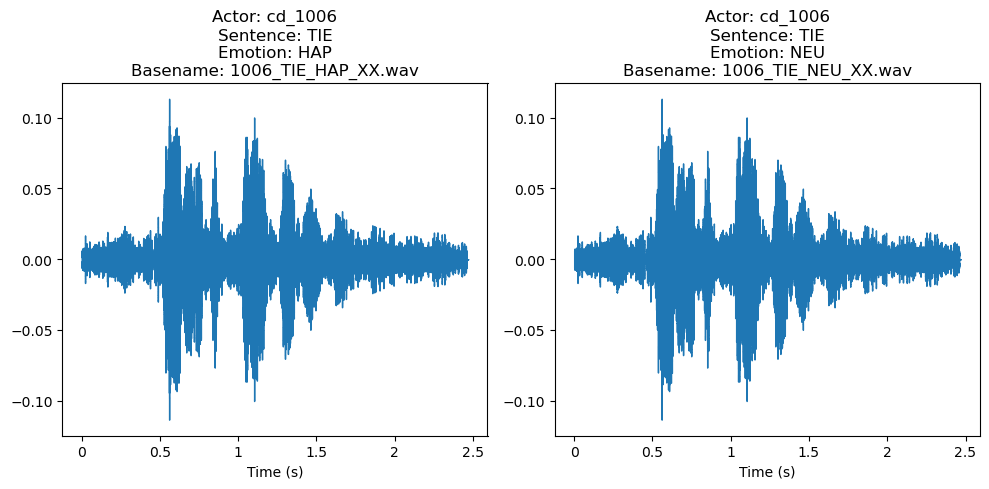

Actor: cd_1013
Sentence: WSI
Emotion: DIS
Basename: 1013_WSI_DIS_XX.wav


Actor: cd_1013
Sentence: WSI
Emotion: SAD
Basename: 1013_WSI_SAD_XX.wav


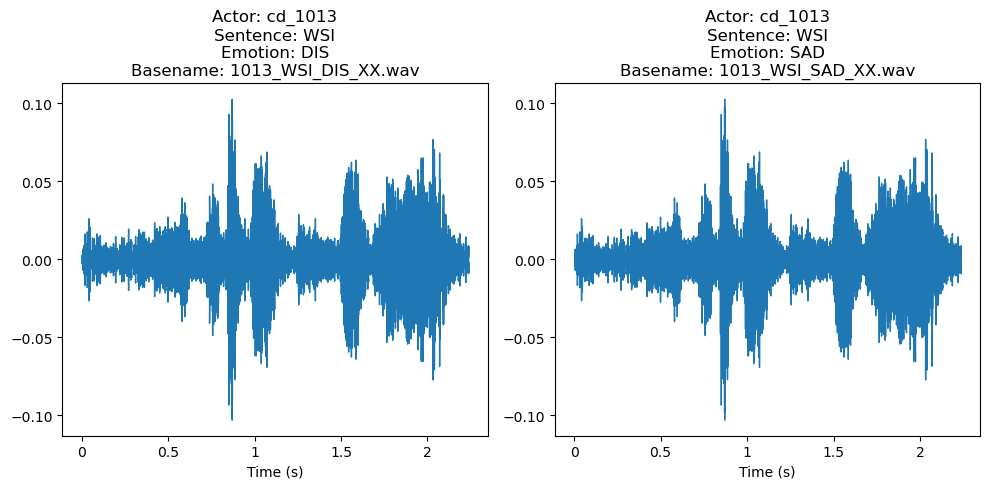

Actor: cd_1017
Sentence: IWW
Emotion: ANG
Basename: 1017_IWW_ANG_XX.wav


Actor: cd_1017
Sentence: IWW
Emotion: FEA
Basename: 1017_IWW_FEA_XX.wav


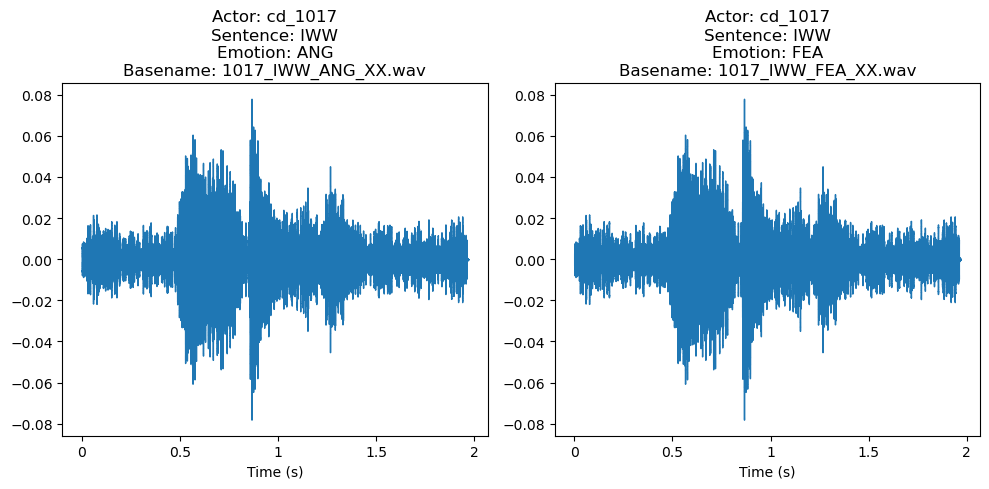

In [20]:
# iterate over the sets of dupiclate arrays
for x in range(len(equivalent_arrays_cd)):
    # run the function to display the waveforms
    set_equiv_analyze(cd_df,array_list,equivalent_arrays_cd[x])


In all three case, we have two files identified as the same actor, speaking the same sentence, with two different emotions. However, the recordings:
- are identified as equivalent using np.equals, and
- have waveforms that appear identical, and
- sound identical to the ear.

Because we do not know which emotion value correctly applies to each set of observations, we will drop all observations identified as duplicates. 

In [21]:
indices_to_drop = []
for x in range(len(equivalent_arrays_cd)):
    indices_to_drop.extend(list(equivalent_arrays_cd[x]))
    
cd_df.drop(indices_to_drop,inplace=True)

In [22]:
cd_df.reset_index(drop=True,inplace=True)

### Categorical features are evenly distributed across emotions

In [23]:
cd_df.select_dtypes(include=['object']).columns

Index(['path', 'basename', 'actor', 'sentence', 'emotion', 'intensity', 'sex',
       'source'],
      dtype='object')

In [24]:
# get the value counts for each column in the labelled dataframe

# get a list of object column names (excluding the float duration_sec for separate analysis with binning)
columns = list(cd_df.select_dtypes(include=['object']).columns)
# remove path and basename since these are unique for each observations
columns.remove('path')
columns.remove('basename')
# int_columns = rv_df.select_dtypes(include=['int32','int64'])

# iterate over the remaining columns names
for col in columns:
        # map all the integer values in the columns to their string values
        series = cd_df[col]
        print(col)
        print(f'{len(series.value_counts())} unique values')
        print('---------')
        print(series.value_counts(normalize=True,ascending=False))
        print('\n')

actor
91 unique values
---------
cd_1001    0.011027
cd_1047    0.011027
cd_1067    0.011027
cd_1066    0.011027
cd_1065    0.011027
             ...   
cd_1013    0.010758
cd_1006    0.010758
cd_1019    0.010221
cd_1009    0.010221
cd_1008    0.010221
Name: actor, Length: 91, dtype: float64


sentence
12 unique values
---------
IEO    0.195804
DFA    0.073427
IOM    0.073427
IWL    0.073427
TAI    0.073427
TSI    0.073427
ITS    0.073292
IWW    0.073158
TIE    0.073023
ITH    0.072620
MTI    0.072620
WSI    0.072351
Name: sentence, dtype: float64


emotion
6 unique values
---------
ANG    0.170791
DIS    0.170791
FEA    0.170791
HAP    0.170791
SAD    0.170791
NEU    0.146046
Name: emotion, dtype: float64


intensity
5 unique values
---------
XX    0.816299
HI    0.061189
LO    0.061189
MD    0.061189
X     0.000134
Name: intensity, dtype: float64


sex
2 unique values
---------
male      0.528241
female    0.471759
Name: sex, dtype: float64


source
1 unique values
---------
crema   

**Observations on the distribution of categorical data**

Actor
- There are 91 unique actors represented, each accounting for between 1.0% and 1.1% of observations.
- The large number of actors and the balanced representation of observations across actors will help prevent our model from overfitting to a handful of speakers.

Statement
- With the exception of IRO (It's eleven o'clock), the statements are equally represented, each accounting for about 7.3% of observations.
- IRO (It's eleven o'clock) accounts for about 20.0% of observations. Although this representation is greater than other statements, we don't expect it to negatively impact modeling.

Emotion
- There are six unique values, five basic emotions and one neutral value.
- The five basic emotions (happy, sad, fearful, angry, disgusted) are equally represented, each accounting for 17.0% of observations.
- The neutral value has slightly lower representation with 14.6% of observations.

Intensity
- The majority, 81.6% of observations are coded as unspecified (XX). Our focus is on emotion, not intensity, so the absence of classification here will not be an issue. We intend to leave intensity in our dataframe to aid in identifying trends in misclassification once we begin modeling.
- A very small portion of observations, 0.01%, are coded as X. This value is not included in the Crema-D data dictionary. We assume it was intended to be XX and will recode it.
- High, Medium and Low intensity are equally represented, each accounting for 6.1% of observations.

Sex
- Males have slightly higher representation (52.8%), but overall the dataset is balanced across sex.

Source
- all these observations are from crema-D

In [25]:
# replace the 'X' value with 'XX' in the intensity column
cd_df['intensity'] = cd_df['intensity'].replace({'X':'XX'})

# display the revised value counts
cd_df['intensity'].value_counts(normalize=True)

XX    0.816434
HI    0.061189
LO    0.061189
MD    0.061189
Name: intensity, dtype: float64

The 'X' values have been successfully replaced with 'XX'

**Balance across sub-groupings**
Let's examine the distribution using groupby to see if any emotions have imbalanced representation of sex or emotion or intensity.

In [26]:
# Let's look at crosstabular representaiton with groupby
cd_df.groupby(['emotion','sex','intensity','actor','sentence']).count()[['path']]

path
emotion sex    intensity actor   sentence      
ANG     female HI        cd_1002 IEO          1
                         cd_1003 IEO          1
                         cd_1004 IEO          1
                         cd_1006 IEO          1
                         cd_1007 IEO          1
...                                         ...
SAD     male   XX        cd_1090 MTI          1
                                 TAI          1
                                 TIE          1
                                 TSI          1
                                 WSI          1

[7436 rows x 1 columns]

For the displayed groupings, every unique combination of emotion, sex, intensity, actor, and statement appears to have one observation. Let's run a count_values to quickly check whether all combinations have the same number of observations.

In [27]:
cd_df.groupby(['emotion','sex','intensity','actor','sentence']).count()[['path']].value_counts()

path
1       7436
dtype: int64

Every combination has one value. The dataset is extremely well-balanced within its categories.

### Duration ranges from 1.3 to 5.0 seconds
- The mean duration is 2.54 seconds.
- The distriubtion of duration is right-skewed and leptokurtic.

Histogram of untrimmed duration
Boxplot of untrimmed duration
Split by gender
Split by emotion

In [28]:
cd_df.describe()

duration_sec
count   7436.000000
mean       2.543141
std        0.506068
min        1.267937
25%        2.202187
50%        2.502500
75%        2.836187
max        5.005000

In [29]:
print('The median value of duration is {:.2f} seconds.'.format(cd_df['duration_sec'].median()))

The median value of duration is 2.50 seconds.


The audio recordings range from 1.3 to 5.0 seconds in length, with a mean length of 2.54 seconds and a median length of 2.50 seconds. These are short clips which allow for faster audio feature extraction.Short clips also make it easier to confine to expressing just a single emotion.

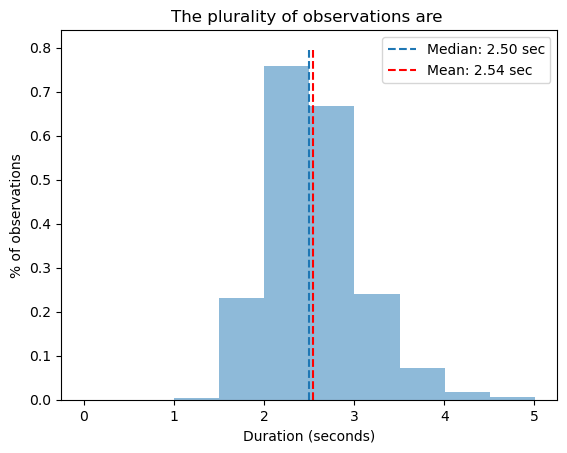

In [30]:
plt.figure()
plt.hist(cd_df['duration_sec'],alpha=0.5,density =True,range=(0, cd_df['duration_sec'].max()))
plt.xlabel('Duration (seconds)')
plt.ylabel('% of observations')
plt.title('The plurality of observations are ')
plt.vlines(cd_df['duration_sec'].median(),ymin=0,ymax=0.8,label='Median: {:.2f} sec'.format(cd_df['duration_sec'].median()),linestyles='--')
plt.vlines(cd_df['duration_sec'].mean(),ymin=0,ymax=0.8,label='Mean: {:.2f} sec'.format(cd_df['duration_sec'].mean()),linestyles='--',color='r')
plt.legend()
plt.show()

The distribution is right-skewed and leptokurtic.

## Rav-Dess
- Published 2018
- 24 actors, half male, half female, speaking two different sentences with seven emotions and two intensities
- Classifications by third party blinded reviewers showed some consistency between the actors intent and the audience perception


### Read in the Ravdess filenames and extract encoded metadata
The Ravdess data consists of .wav audio files. Specific information about each file is contained in the filename.

***Filename labeling conventions***

**Modality**
Modality is a 2 digit number at the start of the file. Each subsequent identifier is separated by a dash (-). The full dataset includes identifiers for audio-only, video-only, and video w/audio.
- 01 = full-AV
- 02 = video-only
- 03 = audio-only
We are only looking at audio-only files, so we expect all files to begin with 03.

**Vocal channel**
- 01 = speech
- 02 = song
We are only looking at speech files, so we expect all data to be coded with 01.

**Emotion**
Emotion codes are below. For emtoion preent in the Crema-D set, we will use the same naming convention used in Crema-D. Emotions not present in the Crema-D dataset (calm and surprised) will be drop due to insufficient representation.
- 01 = neutral (NEU)
- 02 = calm
- 03 = happy (HAP)
- 04 = sad (SAD)
- 05 = angry (ANG)
- 06 = fearful (FEA)
- 07 = disgust (DIS)
- 08 = surprised

**Intensity**
Emotional intensity is coded in the fourth part of the filename. It is encoded as normal or strong. To align with the coding of CREMA-D, we code normal to medium intensity (MD), and we code strong to high intensity (HI).
- 01 = normal (MD)
- 02 = strong (HI)

**Sentence**
Actors spoke from a selection of two sentences.
- 01 = Kids are talking by the door (KTD)
- 02 = Dogs are sitting by the door (DSD)

**Repetition**
Most sentence <> actor <> emotion <> intensity combinations were recorded twice. This column indiciates whether it was the first or second repetition.
- 01 = 1st repetition
- 02 = 2nd repetition

**ActorID**
Actors are numbered from 01 to 24. Odd numbered actors are male, even numbered actors are female.

Filename example: 02-01-06-01-02-01-12.mp4 

- Video-only (02)
- Speech (01)
- Fearful (06)
- Normal intensity (01)
- Statement "dogs" (02)
- 1st Repetition (01)
- 12th Actor (12)
- Female, as the actor ID number is even.

In [31]:
# create a dictionary to map the values in each column to their meaning
# for some columns where we don't want to map to new values, we have created empty dictionaries
rv_meaning_dict = {'modality':{1:'full-AV', 2:'video-only', 3:'audio-only'},
              'vocal_channel':{1:'speech',2:'song'},
              'emotion':{1:'NEU', 2:'calm', 3:'HAP', 4:'SAD', 5:'ANG', 6:'FEA', 7:'DIS', 8:'surprised'},
              'intensity':{1:'MD', 2:'HI'},
              # Let's abbreviate "Kids are talking by the door" to 
              'sentence':{1:"KTD", 2:"DSD"},
              'sex':{},
              'actor':{},
              'repetition':{},
              'path':{},
              'basename':{},
              'duration_sec':{}
                       }

In [32]:
%%time
# instantiate a list to hold file name elements
filename_elements = list()

# iterate over all the files in the .wav files in the ravdess speech subfolders
for file in glob.glob('raw_data/ravdess_speech/*/*.wav', recursive = True):
    # save the path for accessing the file in the future
    row = [file]
    # get the base file name
    basename = os.path.basename(file)
    # save the basename to use for indexing files
    row.append(basename)
    # drop .wav from the basename and then split the filename up using '-' as the delimiter
    row.extend(basename.split('.')[0].split('-'))
    
    # code whether the actor is male or female based on whether the last two digit number
    # in the filename is even or odd
    if int((row[-1]))%2 == 0:
        row.append('female')
    else:
        row.append('male')

    
    
    # get some features from the audio file
    
    # import a wav file using pydub.AudioSegment
    audio_segment = pydub.AudioSegment.from_file(file)
    
    # get the duration
    row.append(audio_segment.duration_seconds)
    
    filename_elements.append(row)

rv_df = pd.DataFrame(filename_elements)

# rename the columns
rv_df.columns = ['path',
                      'basename',
                      'modality',
                      'vocal_channel',
                      'emotion',
                      'intensity',
                      'sentence',
                      'repetition',
                      'actor',
                      'sex',
                      'duration_sec']

CPU times: total: 2.44 s
Wall time: 9.15 s


In [33]:
rv_df

path  \
0     raw_data/ravdess_speech\Actor_01\03-01-01-01-0...   
1     raw_data/ravdess_speech\Actor_01\03-01-01-01-0...   
2     raw_data/ravdess_speech\Actor_01\03-01-01-01-0...   
3     raw_data/ravdess_speech\Actor_01\03-01-01-01-0...   
4     raw_data/ravdess_speech\Actor_01\03-01-02-01-0...   
...                                                 ...   
1435  raw_data/ravdess_speech\Actor_24\03-01-08-01-0...   
1436  raw_data/ravdess_speech\Actor_24\03-01-08-02-0...   
1437  raw_data/ravdess_speech\Actor_24\03-01-08-02-0...   
1438  raw_data/ravdess_speech\Actor_24\03-01-08-02-0...   
1439  raw_data/ravdess_speech\Actor_24\03-01-08-02-0...   

                      basename modality vocal_channel emotion intensity  \
0     03-01-01-01-01-01-01.wav       03            01      01        01   
1     03-01-01-01-01-02-01.wav       03            01      01        01   
2     03-01-01-01-02-01-01.wav       03            01      01        01   
3     03-01-01-01-02-02-01.wav       03            01      01        01   
4     03-01-02-01-01-01-01.wav       03            01      02        01   
...                        ...      ...           ...     ...       ...   
1435  03-01-08-01-02-02-24.wav       03            01      08        01   
1436  03-01-08-02-01-01-24.wav       03            01      08        02   
1437  03-01-08-02-01-02-24.wav       03            01      08        02   
1438  03-01-08-02-02-01-24.wav       03            01      08        02   
1439  03-01-08-02-02-02-24.wav       03            01      08        02   

     sentence repetition actor     sex  duration_sec  
0          01         01    01    male      3.303292  
1          01         02    01    male      3.336667  
2          02         01    01    male      3.269917  
3          02         02    01    male      3.169833  
4          01         01    01    male      3.536854  
...       ...        ...   ...     ...           ...  
1435       02         02    24  female      3.403396  
1436       01         01    24  female      3.937271  
1437       01         02    24  female      3.970625  
1438       02         01    24  female      3.670333  
1439       02         02    24  female      3.636958  

[1440 rows x 11 columns]

In [34]:
print(f'The dataset has {rv_df.shape[0]} observations.')

The dataset has 1440 observations.


This is the number of observations that we expected.

We examine the datatypes.

In [35]:
# Let's examine the datatypes
rv_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440 entries, 0 to 1439
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   path           1440 non-null   object 
 1   basename       1440 non-null   object 
 2   modality       1440 non-null   object 
 3   vocal_channel  1440 non-null   object 
 4   emotion        1440 non-null   object 
 5   intensity      1440 non-null   object 
 6   sentence       1440 non-null   object 
 7   repetition     1440 non-null   object 
 8   actor          1440 non-null   object 
 9   sex            1440 non-null   object 
 10  duration_sec   1440 non-null   float64
dtypes: float64(1), object(10)
memory usage: 123.9+ KB


Except for duration_sec, which is a float, all other columns are objects. Path, basename, and sex should be strings, so we will not change their datatype. For the other features, we convert them to an int datatype, then will replace those int values with the appropriate strings from rv_meaning_dict.

In [36]:
# Convert columns to integers
int_df = rv_df.loc[:,'modality':'actor'].astype(int).copy()
rv_df.loc[:,'modality':'actor'] = int_df

C:\Users\Stonebreaker06\AppData\Local\Temp\ipykernel_9996\1638568629.py:3: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rv_df.loc[:,'modality':'actor'] = int_df


In [37]:
rv_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440 entries, 0 to 1439
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   path           1440 non-null   object 
 1   basename       1440 non-null   object 
 2   modality       1440 non-null   int32  
 3   vocal_channel  1440 non-null   int32  
 4   emotion        1440 non-null   int32  
 5   intensity      1440 non-null   int32  
 6   sentence       1440 non-null   int32  
 7   repetition     1440 non-null   int32  
 8   actor          1440 non-null   int32  
 9   sex            1440 non-null   object 
 10  duration_sec   1440 non-null   float64
dtypes: float64(1), int32(7), object(3)
memory usage: 84.5+ KB


We have successfully converted the identified object columns into int. Let's now replace thoe values with strings from our dictionary.

In [38]:
# Let's check the shape before our replacement operation
rv_df.shape

(1440, 11)

In [39]:
# replacement operation

# store the columns names
column_names = rv_df.columns

# instantiate a list to hold the new columns with replaced values
converted_columns = []

# iterate over the columns in the dataframe
for col in rv_df.columns:
    # conduction a replacement using the values in the dictionary
    # append these new columns to our list
    converted_columns.append(rv_df[col].replace(rv_meaning_dict[col]))

# concatenate the converted columns into the dataframe    
rv_df = pd.concat(converted_columns,axis=1)
# rename the columns
rv_df.columns = column_names
#check the shape
rv_df.shape

(1440, 11)

In [40]:
rv_df.sample(5)

path  \
1167  raw_data/ravdess_speech\Actor_20\03-01-04-02-0...   
796   raw_data/ravdess_speech\Actor_14\03-01-03-02-0...   
496   raw_data/ravdess_speech\Actor_09\03-01-03-02-0...   
215   raw_data/ravdess_speech\Actor_04\03-01-05-02-0...   
520   raw_data/ravdess_speech\Actor_09\03-01-06-02-0...   

                      basename    modality vocal_channel emotion intensity  \
1167  03-01-04-02-02-02-20.wav  audio-only        speech     SAD        HI   
796   03-01-03-02-01-01-14.wav  audio-only        speech     HAP        HI   
496   03-01-03-02-01-01-09.wav  audio-only        speech     HAP        HI   
215   03-01-05-02-02-02-04.wav  audio-only        speech     ANG        HI   
520   03-01-06-02-01-01-09.wav  audio-only        speech     FEA        HI   

     sentence  repetition  actor     sex  duration_sec  
1167      DSD           2     20  female      3.970625  
796       KTD           1     14  female      3.770417  
496       KTD           1      9    male      3.770437  
215       DSD           2      4  female      3.837167  
520       KTD           1      9    male      3.236562

The data has been converted in string with human-readable meaning.

Let's also add a column to identify ravdess as the source of this data since we will be combining it with the Crema-D data shortly. We also add rv_ as a prefix to the actor id.

In [41]:
# create a source column that identifies the provenance of these obsevations
rv_df['source'] = 'ravdess'

# add the prefix 'cd_' to actor for easy identification of the dataset to which the actor belongs
rv_df['actor'] = rv_df['actor'].apply(lambda x: 'rv_' + str(x))

In [42]:
rv_df

path  \
0     raw_data/ravdess_speech\Actor_01\03-01-01-01-0...   
1     raw_data/ravdess_speech\Actor_01\03-01-01-01-0...   
2     raw_data/ravdess_speech\Actor_01\03-01-01-01-0...   
3     raw_data/ravdess_speech\Actor_01\03-01-01-01-0...   
4     raw_data/ravdess_speech\Actor_01\03-01-02-01-0...   
...                                                 ...   
1435  raw_data/ravdess_speech\Actor_24\03-01-08-01-0...   
1436  raw_data/ravdess_speech\Actor_24\03-01-08-02-0...   
1437  raw_data/ravdess_speech\Actor_24\03-01-08-02-0...   
1438  raw_data/ravdess_speech\Actor_24\03-01-08-02-0...   
1439  raw_data/ravdess_speech\Actor_24\03-01-08-02-0...   

                      basename    modality vocal_channel    emotion intensity  \
0     03-01-01-01-01-01-01.wav  audio-only        speech        NEU        MD   
1     03-01-01-01-01-02-01.wav  audio-only        speech        NEU        MD   
2     03-01-01-01-02-01-01.wav  audio-only        speech        NEU        MD   
3     03-01-01-01-02-02-01.wav  audio-only        speech        NEU        MD   
4     03-01-02-01-01-01-01.wav  audio-only        speech       calm        MD   
...                        ...         ...           ...        ...       ...   
1435  03-01-08-01-02-02-24.wav  audio-only        speech  surprised        MD   
1436  03-01-08-02-01-01-24.wav  audio-only        speech  surprised        HI   
1437  03-01-08-02-01-02-24.wav  audio-only        speech  surprised        HI   
1438  03-01-08-02-02-01-24.wav  audio-only        speech  surprised        HI   
1439  03-01-08-02-02-02-24.wav  audio-only        speech  surprised        HI   

     sentence  repetition  actor     sex  duration_sec   source  
0         KTD           1   rv_1    male      3.303292  ravdess  
1         KTD           2   rv_1    male      3.336667  ravdess  
2         DSD           1   rv_1    male      3.269917  ravdess  
3         DSD           2   rv_1    male      3.169833  ravdess  
4         KTD           1   rv_1    male      3.536854  ravdess  
...       ...         ...    ...     ...           ...      ...  
1435      DSD           2  rv_24  female      3.403396  ravdess  
1436      KTD           1  rv_24  female      3.937271  ravdess  
1437      KTD           2  rv_24  female      3.970625  ravdess  
1438      DSD           1  rv_24  female      3.670333  ravdess  
1439      DSD           2  rv_24  female      3.636958  ravdess  

[1440 rows x 12 columns]

The modifications are successful: 
- 'source' is showing 'ravdess'
- 'actor' now has the prefix 'rv_'

Let's now examine the datatypes:

In [43]:
rv_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440 entries, 0 to 1439
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   path           1440 non-null   object 
 1   basename       1440 non-null   object 
 2   modality       1440 non-null   object 
 3   vocal_channel  1440 non-null   object 
 4   emotion        1440 non-null   object 
 5   intensity      1440 non-null   object 
 6   sentence       1440 non-null   object 
 7   repetition     1440 non-null   int32  
 8   actor          1440 non-null   object 
 9   sex            1440 non-null   object 
 10  duration_sec   1440 non-null   float64
 11  source         1440 non-null   object 
dtypes: float64(1), int32(1), object(10)
memory usage: 129.5+ KB


With the exception of duration_sec and repetition, all of the columns have a datatype of object and hold strings. The column duration_sec is a float which is appropriate for identifying the length of the recordings in seconds. The column repetition is an integer which is appropriate for identifying whether it was the first or second repetition.

Let's look for duplicates and null values before further examining the distribution of this dataset.

### There are no null values or duplicate rows

In [44]:
# use the previously defined funciton to check this
nulls_dups(rv_df)

NULLS
-------
There are 0 null values.
Columns: 0 columns have null values.
Columns: 0.00% of columns have null values.
Rows: 0 rows have null values.
Rows: 0.00% of rows have null values.

DUPLICATE ROWS
-----------
Rows: 0 rows are exact duplicates.
Rows: 0.00% of rows are exact duplicates.



### There are two audio files identified as duplicated; the second instance is dropped.

**Check for duplicate audio files**
1. Define a function to check for duplicates
2. Extract audio
3. Run the function

In [45]:
%%time

# instantiate a list of hold the arrays of the audio files
array_list_rv = []

# iterate over the dataframe's indices
for index in range(0,len(rv_df['path'])):
    # extract the numpy audio array and the sample rate
    y,sr = librosa.load(rv_df['path'][index])
    # append the arrays to the list
    array_list_rv.append(y)

CPU times: total: 3min 23s
Wall time: 3min 26s


In [46]:
%%time
# use the previously defined funciton to check for duplicates
equivalent_arrays_rv = equivalence_for_list_of_arrays(array_list_rv)
equivalent_arrays_rv

There are 1 duplications
CPU times: total: 7.97 s
Wall time: 7.97 s


[{374, 375}]

**Examine the duplicate arrays**

Actor: rv_7
Sentence: DSD
Emotion: HAP
Basename: 03-01-03-01-02-01-07.wav


Actor: rv_7
Sentence: DSD
Emotion: HAP
Basename: 03-01-03-01-02-02-07.wav


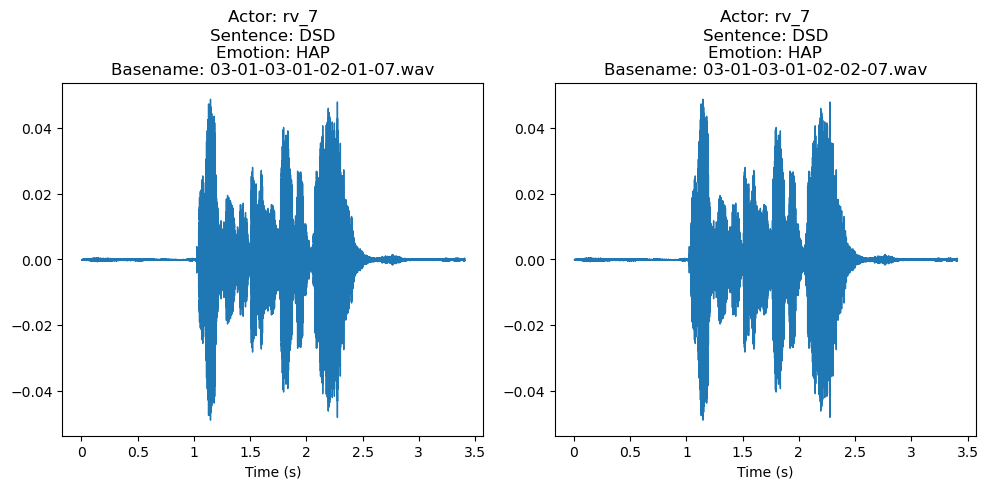

In [47]:
# iterate over the sets of equivalent arrays
for x in range(len(equivalent_arrays_rv)):
    # use the previously defined funciton to show the details
    set_equiv_analyze(rv_df,array_list_rv,equivalent_arrays_rv[x])


In this case, we have two files identified as the same actor, speaking the same sentence, with two different emotions. The second to last two-digit codes indicate that these are different recordings of the same sentence, actor, emotion. However, the recordings:
- are identified as equivalent using np.array_equal, and
- have waveforms that appear identical, and
- sound identical to the ear.

We will drop the second instance of this recording. 

In [48]:
print(f'Before the drop, rv_df has {len(rv_df)} observations.')
rv_df.drop(375,inplace=True)
rv_df.reset_index(drop=True,inplace=True)
print(f'After the drop, rv_df has {len(rv_df)} observations.')

Before the drop, rv_df has 1440 observations.
After the drop, rv_df has 1439 observations.


### Categorical variables are evenly distributed across emotions

In [49]:
# get the value counts for each column in the labelled dataframe

# get a list of object column names (excluding the float duration_sec for separate analysis with binning)
columns = list(rv_df.select_dtypes(include=['object','int32']).columns)
# remove path and basename since these are unique for each observations
columns.remove('path')
columns.remove('basename')
#int_columns = rv_df.select_dtypes(include=['int32','int64'])

# iterate over the remaining columns names
for col in columns:
        series = rv_df[col]
        print(col)
        print(f'{len(series.value_counts())} unique values')
        print('---------')
        print(series.value_counts(normalize=True,ascending=False))
        print('\n')

modality
1 unique values
---------
audio-only    1.0
Name: modality, dtype: float64


vocal_channel
1 unique values
---------
speech    1.0
Name: vocal_channel, dtype: float64


emotion
8 unique values
---------
calm         0.133426
SAD          0.133426
ANG          0.133426
FEA          0.133426
DIS          0.133426
surprised    0.133426
HAP          0.132731
NEU          0.066713
Name: emotion, dtype: float64


intensity
2 unique values
---------
MD    0.533009
HI    0.466991
Name: intensity, dtype: float64


sentence
2 unique values
---------
KTD    0.500347
DSD    0.499653
Name: sentence, dtype: float64


repetition
2 unique values
---------
1    0.500347
2    0.499653
Name: repetition, dtype: float64


actor
24 unique values
---------
rv_1     0.041696
rv_2     0.041696
rv_23    0.041696
rv_22    0.041696
rv_21    0.041696
rv_20    0.041696
rv_19    0.041696
rv_18    0.041696
rv_17    0.041696
rv_16    0.041696
rv_15    0.041696
rv_14    0.041696
rv_13    0.041696
rv_12    0.04

**Observations on the distribution of categorical data**

Modality
- All observation are audio-only, which is as intended. We will drop this column.

Vocal_channel
- All observations are speech, which is as intended. We will drop this column.

Emotion
- There are eight unique values.
- Similar to Crema-D, there are the five basic emotions and one neutral value. Calm and surprised are also present. We will now drop those since we are focusing only emotions present in both datasets.
- With the exception of neutral, all emotions are equally represented, each accounting for 13.3% of observations.
- The neutral value has slightly lower representation with 6.7% of observations.

Intensity
- The majority, 53.3% of observations, are coded as strong (HI). The remainder, 46.7% of observations, are coded as normal (MD).
- Our focus is on emotion, not intensity, so we will include observations of both intensities to create a more robust model.

Statement
- Both statements have equal representation.

Repetition
- There are an equal number of first and second repetition observations. We will drop this column since it is not present in the crema-D dataset.

Actor
- There are 24 unique actors represented, each accounting for between 4.2% of observations.
- The large number of actors and the balanced representation of observations across actors will help prevent our model from overfitting to a handful of speakers.

Sex
- male and female have equal representation.

Source
- all these observations are from Ravdess

**Dropping rows and columns**

Let's drop the identified columns: modality and vocal channel

In [50]:
rv_df.shape

(1439, 12)

In [51]:
# drop columns
rv_df.drop(columns=['modality','vocal_channel','repetition'],inplace=True)
rv_df.shape

(1439, 9)

The drop operation has not changed the number of rows, but it has reduced the column count by three. The drop operation is successful.

Let's now drop the obervations for 'calm' and 'surprised'.

In [52]:
calm_observations = rv_df[rv_df['emotion'] == 'calm'].shape[0]
print(f'There are {calm_observations} observations coded as "calm".')
surprised_observations = rv_df[rv_df['emotion'] == 'surprised'].shape[0]
print(f'There are {surprised_observations} observations coded as "surprised".\n')

print(f'After dropping "calm" and "surprised", the total number of observations will be reduced from {rv_df.shape[0]} to {rv_df.shape[0] - calm_observations - surprised_observations}.')

There are 192 observations coded as "calm".
There are 192 observations coded as "surprised".

After dropping "calm" and "surprised", the total number of observations will be reduced from 1439 to 1055.


In [53]:
rv_df = rv_df.drop(rv_df[(rv_df['emotion'] == 'calm') | (rv_df['emotion'] == 'surprised')].index)

In [54]:
print(f'After dropping "calm" and "surprised", there are now {rv_df.shape[0]} observations.')

After dropping "calm" and "surprised", there are now 1055 observations.


**Balance across sub-groupings**
Let's examine the distribution using groupby to see if any emotions have imbalanced representation of sex or emotion or intensity.

In [55]:
# Let's look at crosstabular representaiton with groupby
rv_df.groupby(['emotion','sex','intensity','actor','sentence']).count()[['path']]

path
emotion sex    intensity actor sentence      
ANG     female HI        rv_10 DSD          2
                               KTD          2
                         rv_12 DSD          2
                               KTD          2
                         rv_14 DSD          2
...                                       ...
SAD     male   MD        rv_5  KTD          2
                         rv_7  DSD          2
                               KTD          2
                         rv_9  DSD          2
                               KTD          2

[528 rows x 1 columns]

For the displayed groupings, every unique combination of emotion, sex, intensity, actor, and statement appears tohave two observations. Let's run a count_values to quickly check whether all combinations have the same number of observations.

In [56]:
rv_df.groupby(['emotion','sex','intensity','actor','sentence']).count()[['path']].value_counts()

path
2       527
1         1
dtype: int64

With the exception of a single instance, every combination has two observations. The single instance with only one observation is the result of dropping the duplicate recording earlier.

The dataset is extremely well-balanced within its categories.

### Duration ranges from 3.1 to 5.3 seconds
- The mean duration is 3.72 seconds.
- The distriubtion of duration is slightly right-skewed and more leptokurtic than Crema-D.

Histogram of untrimmed duration
Boxplot of untrimmed duration
Split by gender
Split by emotion

In [57]:
rv_df[['duration_sec']].describe()

duration_sec
count   1055.000000
mean       3.722424
std        0.337234
min        3.069729
25%        3.503500
50%        3.670333
75%        3.903896
max        5.271937

In [58]:
print('The median value of duration is {:.2f} seconds.'.format(rv_df['duration_sec'].median()))

The median value of duration is 3.67 seconds.


The audio recordings range from 3.1 to 5.3 seconds in length, with a mean length of 3.72 seconds and a median length of 3.7 seconds. These clips are longer than those of the Crema-D set.

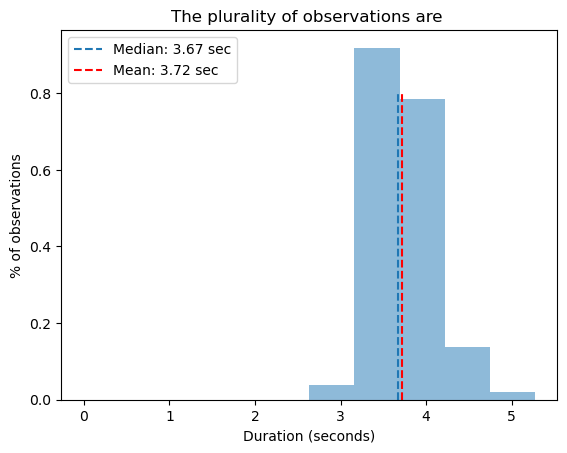

In [59]:
plt.figure()
plt.hist(rv_df['duration_sec'],alpha=0.5,density =True,range=(0, rv_df['duration_sec'].max()))
plt.xlabel('Duration (seconds)')
plt.ylabel('% of observations')
plt.title('The plurality of observations are ')
plt.vlines(rv_df['duration_sec'].median(),ymin=0,ymax=0.8,label='Median: {:.2f} sec'.format(rv_df['duration_sec'].median()),linestyles='--')
plt.vlines(rv_df['duration_sec'].mean(),ymin=0,ymax=0.8,label='Mean: {:.2f} sec'.format(rv_df['duration_sec'].mean()),linestyles='--',color='r')
plt.legend()
plt.show()

The distribution is slightly right-skewed and more leptokurtic than Crema-D. Before determining whether the difference in lengths between the datasets is relevant, we will need to remove silence from the beginning and end of all recordings.

Before that, we will concatenate the dataframes of each dataset.

## Combine the two datasets

### Concatenate the two dataframes

In [60]:
print(f'cd_df shape: {cd_df.shape}')
print(f'rv_df shape: {rv_df.shape}')

print(f'\nAfter concatenation, the new dataframe should have:\n{cd_df.shape[0] + rv_df.shape[0]} rows, and\n{cd_df.shape[1]} columns')

cd_df shape: (7436, 9)
rv_df shape: (1055, 9)

After concatenation, the new dataframe should have:
8491 rows, and
9 columns


In [61]:
# confirm whether the two dataframes have the same columns
set(cd_df.columns) == set(rv_df.columns)

True

The column names of both dataframes are identical.

In [62]:
df = pd.concat([cd_df,rv_df],axis=0)
df.reset_index(drop=True,inplace=True)
df.shape

(8491, 9)

The concatenation is successful.

### Data dictionary

In [63]:
# List out the columns in the dataframe and datatype of each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8491 entries, 0 to 8490
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   path          8491 non-null   object 
 1   basename      8491 non-null   object 
 2   actor         8491 non-null   object 
 3   sentence      8491 non-null   object 
 4   emotion       8491 non-null   object 
 5   intensity     8491 non-null   object 
 6   duration_sec  8491 non-null   float64
 7   sex           8491 non-null   object 
 8   source        8491 non-null   object 
dtypes: float64(1), object(8)
memory usage: 597.1+ KB


***Data dictionary***

**path**

Datatype is object and contains strings. This is the path for accessing the audio file in our local machine.

**basename**

Datatype is object and contains strings. This the filename.

**actor**

Datatype is object and contains strings. A unique id for each actor. Actors from the Crema-D dataset are prefixed with 'cd_', actors from Ravdess are prefixed with 'rv_'.

**sentence**

Datatype is object and contains strings. Actors spoke from a selection of 14 sentences:
- IEO - It's eleven o'clock.
- TIE - That is exactly what happened.
- IOM - I'm on my way to the meeting.
- IWW - I wonder what this is about.
- TAI - The airplane is almost full.
- MTI - Maybe tomorrow it will be cold.
- IWL - I would like a new alarm clock.
- ITH - I think I have a doctor's appointment.
- DFA - Don't forget a jacket.
- ITS - I think I've seen this before.
- TSI - The surface is slick.
- WSI - We'll stop in a couple of minutes.
- KTD - Kids are talking by the door.
- DSD - Dogs are sitting by the door.

**emotion**

Datatype is object and contains strings. Emotion is coded in the third part of the filename with the three letter code below:
- NEU - neutral
- HAP - happy
- SAD - sad
- FEA - fear
- AND - anger
- DIS - disgust

**intensity**

Datatype is object and contains strings. The emotional intensity that the actor intended to express.
- Low (LO)
- Normal/Medium (MD)
- High (HI)
- Unspecified (XX)

**duration_sec**

Datatype is float64. The legnth of the raw audio file without trimming off silence form the beginning or end. 

**sex**

Datatype is object and contains strings. Whether the actor is female or male.

**source**

Datatype is object and contains strings. Whether the obervation came from Crema-D or Ravdess

### After concatenating the two datasets, categorical variables are still evenly distributed across emotions

In [64]:
# get the value counts for each column in the labelled dataframe

# get a list of object column names (excluding the float duration_sec for separate analysis with binning)
columns = list(df.select_dtypes(include=['object']).columns)
# remove path and basename since these are unique for each observations
columns.remove('path')
columns.remove('basename')

# iterate over the remaining columns names
for col in columns:
        series = df[col]
        print(col)
        print(f'{len(series.value_counts())} unique values')
        print('---------')
        print(series.value_counts(normalize=True,ascending=False))
        print('\n')

actor
115 unique values
---------
cd_1001    0.009657
cd_1069    0.009657
cd_1067    0.009657
cd_1066    0.009657
cd_1065    0.009657
             ...   
rv_3       0.005182
rv_2       0.005182
rv_1       0.005182
rv_24      0.005182
rv_7       0.005064
Name: actor, Length: 115, dtype: float64


sentence
14 unique values
---------
IEO    0.171476
DFA    0.064303
IOM    0.064303
IWL    0.064303
TAI    0.064303
TSI    0.064303
ITS    0.064186
IWW    0.064068
TIE    0.063950
ITH    0.063597
MTI    0.063597
WSI    0.063361
KTD    0.062183
DSD    0.062066
Name: sentence, dtype: float64


emotion
6 unique values
---------
ANG    0.172182
DIS    0.172182
FEA    0.172182
SAD    0.172182
HAP    0.172065
NEU    0.139206
Name: emotion, dtype: float64


intensity
4 unique values
---------
XX    0.714992
MD    0.121305
HI    0.110117
LO    0.053586
Name: intensity, dtype: float64


sex
2 unique values
---------
male      0.524673
female    0.475327
Name: sex, dtype: float64


source
2 unique values

**Observations on the distribution of categorical data**

Actor
- There are 115 unique actors represented, each accounting for between 0.5% and 1.0% of observations.
- Within each Crema-D, we saw earlier that each actor almost identical amounts of ovservations (1.0% to 1.1%)
- Within Ravdess, we saw that all actors accounted for identical amounts of observations.
- After combining the dataset, crema-d actors each accoutn for about 1.0% of observations and Ravdess actors each account for 0.5% of observations.

Sentence
- With the exception of IRO (It's eleven o'clock), the statements are equally represented, each accounting for 6.2% to 6.4% of observations.
- IRO (It's eleven o'clock) accounts for about 17.1% of observations. Although this representation is greater than other statements, we don't expect it to negatively impact modeling.

Emotion
- There are six unique values, five basic emotions and one neutral value.
- The five basic emotions (happy, sad, fearful, angry, disgusted) are equally represented, each accounting for 17.2% of observations.
- The neutral value has slightly lower representation with 13.9% of observations.

Intensity
- The majority, 71.5% of observations, are coded as unspecified (XX). Our focus is on emotion, not intensity, so the absence of classification here will not be an issue. We intend to leave intensity in our dataframe to aid in identifying trends in misclassification once we begin modeling.
- Low intensity has the least representation, with only 5.4% of observations.
- Medium and High acoount for 12.1% and 11.0% of observations, respectively.

Sex
- Males have slightly higher representation (52.5%), but overall the dataset is balanced across sex.

Source
- 87.6% observations are from crema-D
- 12.4% observations are from Ravdess

**Examining distribution within emotions in greater detail**
- We begin by looking at how many unqiue male and female actors generated recordings for each emotion

In [65]:
df.groupby(['emotion','sex']).nunique()['actor']

emotion  sex   
ANG      female    55
         male      60
DIS      female    55
         male      60
FEA      female    55
         male      60
HAP      female    55
         male      60
NEU      female    55
         male      60
SAD      female    55
         male      60
Name: actor, dtype: int64

All 115 actors (55 female and 60 male) generated recording for each of the 6 emotions. We have 100% participation across emotions.

Let's examine how many of our 14 sentences were used by each gender group of actors for each emotion.

In [66]:
df.groupby(['emotion','sex']).nunique()['sentence']

emotion  sex   
ANG      female    14
         male      14
DIS      female    14
         male      14
FEA      female    14
         male      14
HAP      female    14
         male      14
NEU      female    14
         male      14
SAD      female    14
         male      14
Name: sentence, dtype: int64

Both male and female actors used all 14 sentences in making recordings for each emotion. Let's examine how many different recordings each actor contributed to each emotion.

In [67]:
df.groupby(['emotion','actor']).nunique()['path'].value_counts(normalize=True).sort_index(ascending=False)

14    0.630435
13    0.028986
12    0.123188
11    0.008696
8     0.172464
7     0.001449
4     0.034783
Name: path, dtype: float64

**Observations**
- 63.8% of the time, actors contributed 14 different recordings to an emotion.
- 78.1% of the time, actors contributed more than 10 different recordings to an emotion.
- Only 20.9% of the time did actors contribute less than ten recordings to an emotion and of those times, most were still a contribution of 8 recordings.

Overall, we conclude that:
- each emotion has a near equal representation of male and female actors,
- each emotion has 115 different actors contributing recordings,
- each emotion has significant contributions from almost every actor, and
- in sum, there is excellent balance of a variety of actors and recordings for each emotion.

## Trimming silence off the beginning and end reduces mean duration from 2.5 to 1.3 seconds

Before we examine duration and tempo across recordings, we will trim off silence from the beginning and end of each recording. We will follow this process:
1. Examine silence in an example audio clip
2. Trim off silence from five samples; examine waveform and audio to ensure that neither too much or too little was removed
3. Trim silence off all recordings and store the trimmed length of all recordings. Extract descriptive features during the trimming process.

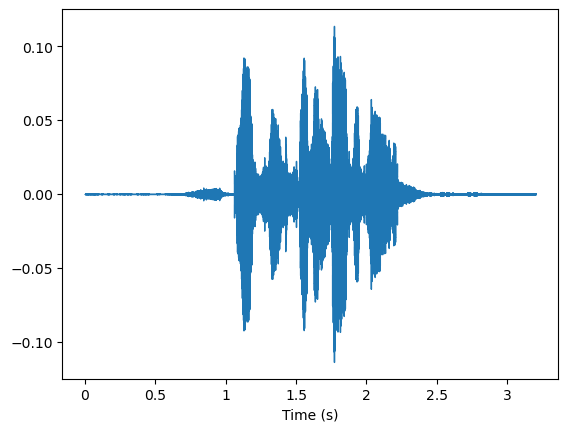

In [68]:
# Plot waveform and listen to audio for an example audio clip

# extract audio array and sample rate from an example file
y,sr = librosa.load('raw_data/ravdess_speech\\Actor_12\\03-01-06-01-02-02-12.wav')
plt.figure()
librosa.display.waveshow(y, sr=sr,x_axis='s')
plt.show()
display(Audio(data=y, rate=sr))

**There is substantial silence at the beginning and end of the audio clip**

We can see the silence in the waveform as the flatness at the beginning and end of the plot. We can also hear silence at the beginning and end of the recording.

We will sample five recordings, trim the silence and compare the before and after to ensure an appropriate amount of silence was trimmed.

In [69]:
# Sample five recordings
samples_5 = df['path'].sample(n=5, random_state=10)

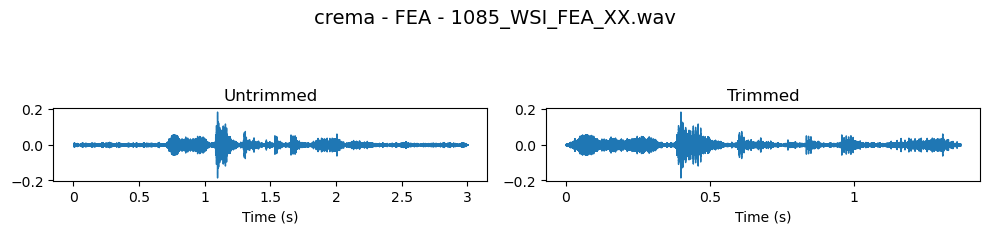

Untrimmed


Trimmed


-------------------------------------


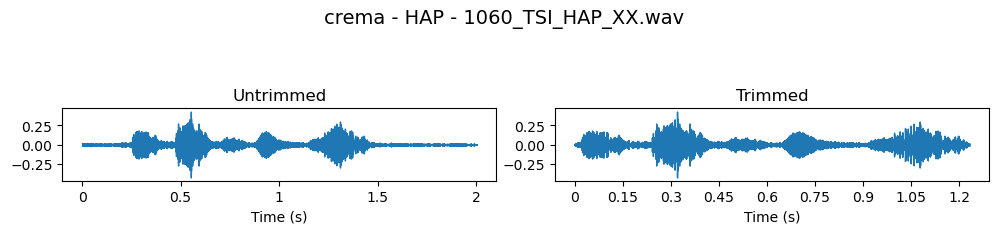

Untrimmed


Trimmed


-------------------------------------


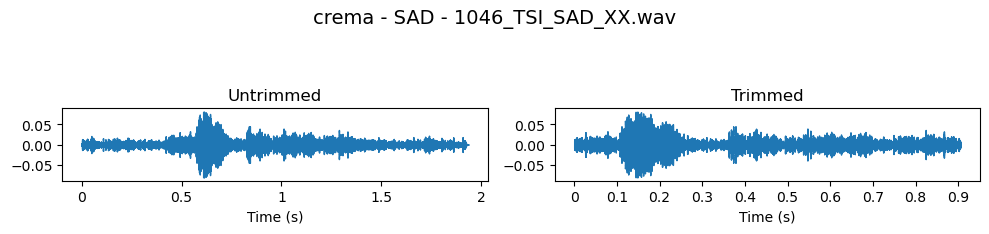

Untrimmed


Trimmed


-------------------------------------


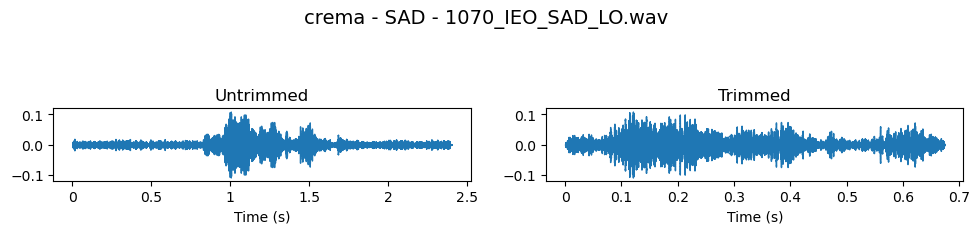

Untrimmed


Trimmed


-------------------------------------


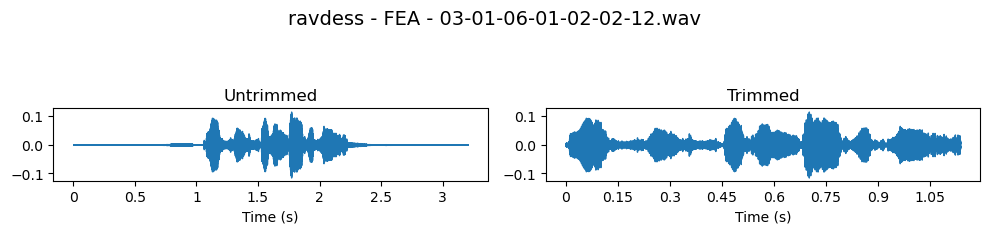

Untrimmed


Trimmed


-------------------------------------


In [71]:
# Plot waveform and listen to audio for the samples recordings

for index, file in samples_5.items():
    y,sr = librosa.load(file)
    #trim silence off the audio with a threshold of 20dB
    yt, i = librosa.effects.trim(y,top_db=11)

    
    plt.subplots(1,2,figsize=(10,2))
    plt.suptitle(df.loc[index,'source'] + ' - ' + df.loc[index,'emotion'] + ' - ' + df.loc[index,'basename'],y=1.15,fontsize=14)    
    plt.subplot(1,2,1)

    librosa.display.waveshow(y, sr=sr,x_axis='s')
    plt.title('Untrimmed')
    
    plt.subplot(1,2,2)
    librosa.display.waveshow(yt, sr=sr,x_axis='s')
    plt.title('Trimmed')
    plt.tight_layout()
    plt.show()
    print('Untrimmed')
    display(Audio(data=y, rate=sr))
    print('Trimmed')
    display(Audio(data=yt, rate=sr))
    print('-------------------------------------')

**Observations on untrimmed samples**
- All samples run for close to a second before speech starts; given that the longest recording in the dataset is only five seconds, this is a significant amount of silence. This silence can be observed when listening the samples and also when looking at the waveform and seeing amplitude fluctuations staying very close to zero.
- Most samples also have silence at the end as well.
- The 'silence' of the crema-D recordings is much noisier than that of ravdess. Crema-D seems to have a lower production quality with a noisier background. We do not expect this negatively impact modeling though; the model should be able to identify emotion even in less than perfect recording environments.

**Observations after trimming**
- Silence is removed
- Content is preserved

We will now trim all the audio files and add the trimmed duration to the data and store the sample rate and numpy array of each recording in a dictionary. At the same time, we will extract some descriptive features from the trimmed audio.

In [72]:
%%time
# intialize a dictionary to hold the trimmed audio
trimmed_audio_dict = {}
# initialize a progress counter
count = 0

# iterate over all of th file paths
for index, file in df['path'].items():
    count += 1
    print(f'Processing file {count} of {len(df)}')
    # load the audio
    y,sr = librosa.load(file)
    # trim the audio
    y, i = librosa.effects.trim(y,top_db=11)
    # store the sample rate and trimmed audio in a dictionary
    trimmed_audio_dict[df.loc[index,'basename']] = {}
    trimmed_audio_dict[df.loc[index,'basename']]['y'] = y
    trimmed_audio_dict[df.loc[index,'basename']]['sr'] = sr
    #get trimmed duration
    df.loc[index,'trimmed_duration_sec'] = librosa.get_duration(y=y,sr=sr)
    # calculate tempo
    df.loc[index,'tempo'] = librosa.beat.beat_track(y=y,sr=sr)[0]
    # calculate zero-crossing rate
    df.loc[index,'avg_zero_crossing_rate'] = np.mean(librosa.feature.zero_crossing_rate(y))
    # calculate spectral centroid
    df.loc[index,'avg_spectral_centroid'] = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
    # calculate spectral flatness
    df.loc[index,'avg_spectral_flatness'] = np.mean(librosa.feature.spectral_flatness(y=y))
    # calculate spectral rolloff
    df.loc[index,'avg_spectral_rolloff'] = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))
    # calculate spectral bandwidth
    df.loc[index,'avg_spectral_bandwidth'] = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))

Processing file 1 of 8491
Processing file 2 of 8491
Processing file 3 of 8491
Processing file 4 of 8491
Processing file 5 of 8491
Processing file 6 of 8491
Processing file 7 of 8491
Processing file 8 of 8491
Processing file 9 of 8491
Processing file 10 of 8491
Processing file 11 of 8491
Processing file 12 of 8491
Processing file 13 of 8491
Processing file 14 of 8491
Processing file 15 of 8491
Processing file 16 of 8491
Processing file 17 of 8491
Processing file 18 of 8491
Processing file 19 of 8491
Processing file 20 of 8491
Processing file 21 of 8491
Processing file 22 of 8491
Processing file 23 of 8491
Processing file 24 of 8491
Processing file 25 of 8491
Processing file 26 of 8491
Processing file 27 of 8491
Processing file 28 of 8491
Processing file 29 of 8491
Processing file 30 of 8491
Processing file 31 of 8491
Processing file 32 of 8491
Processing file 33 of 8491
Processing file 34 of 8491
Processing file 35 of 8491
Processing file 36 of 8491
Processing file 37 of 8491
Processing

Processing file 299 of 8491
Processing file 300 of 8491
Processing file 301 of 8491
Processing file 302 of 8491
Processing file 303 of 8491
Processing file 304 of 8491
Processing file 305 of 8491
Processing file 306 of 8491
Processing file 307 of 8491
Processing file 308 of 8491
Processing file 309 of 8491
Processing file 310 of 8491
Processing file 311 of 8491
Processing file 312 of 8491
Processing file 313 of 8491
Processing file 314 of 8491
Processing file 315 of 8491
Processing file 316 of 8491
Processing file 317 of 8491
Processing file 318 of 8491
Processing file 319 of 8491
Processing file 320 of 8491
Processing file 321 of 8491
Processing file 322 of 8491
Processing file 323 of 8491
Processing file 324 of 8491
Processing file 325 of 8491
Processing file 326 of 8491
Processing file 327 of 8491
Processing file 328 of 8491
Processing file 329 of 8491
Processing file 330 of 8491
Processing file 331 of 8491
Processing file 332 of 8491
Processing file 333 of 8491
Processing file 334 

Processing file 592 of 8491
Processing file 593 of 8491
Processing file 594 of 8491
Processing file 595 of 8491
Processing file 596 of 8491
Processing file 597 of 8491
Processing file 598 of 8491
Processing file 599 of 8491
Processing file 600 of 8491
Processing file 601 of 8491
Processing file 602 of 8491
Processing file 603 of 8491
Processing file 604 of 8491
Processing file 605 of 8491
Processing file 606 of 8491
Processing file 607 of 8491
Processing file 608 of 8491
Processing file 609 of 8491
Processing file 610 of 8491
Processing file 611 of 8491
Processing file 612 of 8491
Processing file 613 of 8491
Processing file 614 of 8491
Processing file 615 of 8491
Processing file 616 of 8491
Processing file 617 of 8491
Processing file 618 of 8491
Processing file 619 of 8491
Processing file 620 of 8491
Processing file 621 of 8491
Processing file 622 of 8491
Processing file 623 of 8491
Processing file 624 of 8491
Processing file 625 of 8491
Processing file 626 of 8491
Processing file 627 

Processing file 886 of 8491
Processing file 887 of 8491
Processing file 888 of 8491
Processing file 889 of 8491
Processing file 890 of 8491
Processing file 891 of 8491
Processing file 892 of 8491
Processing file 893 of 8491
Processing file 894 of 8491
Processing file 895 of 8491
Processing file 896 of 8491
Processing file 897 of 8491
Processing file 898 of 8491
Processing file 899 of 8491
Processing file 900 of 8491
Processing file 901 of 8491
Processing file 902 of 8491
Processing file 903 of 8491
Processing file 904 of 8491
Processing file 905 of 8491
Processing file 906 of 8491
Processing file 907 of 8491
Processing file 908 of 8491
Processing file 909 of 8491
Processing file 910 of 8491
Processing file 911 of 8491
Processing file 912 of 8491
Processing file 913 of 8491
Processing file 914 of 8491
Processing file 915 of 8491
Processing file 916 of 8491
Processing file 917 of 8491
Processing file 918 of 8491
Processing file 919 of 8491
Processing file 920 of 8491
Processing file 921 

Processing file 1173 of 8491
Processing file 1174 of 8491
Processing file 1175 of 8491
Processing file 1176 of 8491
Processing file 1177 of 8491
Processing file 1178 of 8491
Processing file 1179 of 8491
Processing file 1180 of 8491
Processing file 1181 of 8491
Processing file 1182 of 8491
Processing file 1183 of 8491
Processing file 1184 of 8491
Processing file 1185 of 8491
Processing file 1186 of 8491
Processing file 1187 of 8491
Processing file 1188 of 8491
Processing file 1189 of 8491
Processing file 1190 of 8491
Processing file 1191 of 8491
Processing file 1192 of 8491
Processing file 1193 of 8491
Processing file 1194 of 8491
Processing file 1195 of 8491
Processing file 1196 of 8491
Processing file 1197 of 8491
Processing file 1198 of 8491
Processing file 1199 of 8491
Processing file 1200 of 8491
Processing file 1201 of 8491
Processing file 1202 of 8491
Processing file 1203 of 8491
Processing file 1204 of 8491
Processing file 1205 of 8491
Processing file 1206 of 8491
Processing fil

Processing file 1456 of 8491
Processing file 1457 of 8491
Processing file 1458 of 8491
Processing file 1459 of 8491
Processing file 1460 of 8491
Processing file 1461 of 8491
Processing file 1462 of 8491
Processing file 1463 of 8491
Processing file 1464 of 8491
Processing file 1465 of 8491
Processing file 1466 of 8491
Processing file 1467 of 8491
Processing file 1468 of 8491
Processing file 1469 of 8491
Processing file 1470 of 8491
Processing file 1471 of 8491
Processing file 1472 of 8491
Processing file 1473 of 8491
Processing file 1474 of 8491
Processing file 1475 of 8491
Processing file 1476 of 8491
Processing file 1477 of 8491
Processing file 1478 of 8491
Processing file 1479 of 8491
Processing file 1480 of 8491
Processing file 1481 of 8491
Processing file 1482 of 8491
Processing file 1483 of 8491
Processing file 1484 of 8491
Processing file 1485 of 8491
Processing file 1486 of 8491
Processing file 1487 of 8491
Processing file 1488 of 8491
Processing file 1489 of 8491
Processing fil

Processing file 1740 of 8491
Processing file 1741 of 8491
Processing file 1742 of 8491
Processing file 1743 of 8491
Processing file 1744 of 8491
Processing file 1745 of 8491
Processing file 1746 of 8491
Processing file 1747 of 8491
Processing file 1748 of 8491
Processing file 1749 of 8491
Processing file 1750 of 8491
Processing file 1751 of 8491
Processing file 1752 of 8491
Processing file 1753 of 8491
Processing file 1754 of 8491
Processing file 1755 of 8491
Processing file 1756 of 8491
Processing file 1757 of 8491
Processing file 1758 of 8491
Processing file 1759 of 8491
Processing file 1760 of 8491
Processing file 1761 of 8491
Processing file 1762 of 8491
Processing file 1763 of 8491
Processing file 1764 of 8491
Processing file 1765 of 8491
Processing file 1766 of 8491
Processing file 1767 of 8491
Processing file 1768 of 8491
Processing file 1769 of 8491
Processing file 1770 of 8491
Processing file 1771 of 8491
Processing file 1772 of 8491
Processing file 1773 of 8491
Processing fil

Processing file 2023 of 8491
Processing file 2024 of 8491
Processing file 2025 of 8491
Processing file 2026 of 8491
Processing file 2027 of 8491
Processing file 2028 of 8491
Processing file 2029 of 8491
Processing file 2030 of 8491
Processing file 2031 of 8491
Processing file 2032 of 8491
Processing file 2033 of 8491
Processing file 2034 of 8491
Processing file 2035 of 8491
Processing file 2036 of 8491
Processing file 2037 of 8491
Processing file 2038 of 8491
Processing file 2039 of 8491
Processing file 2040 of 8491
Processing file 2041 of 8491
Processing file 2042 of 8491
Processing file 2043 of 8491
Processing file 2044 of 8491
Processing file 2045 of 8491
Processing file 2046 of 8491
Processing file 2047 of 8491
Processing file 2048 of 8491
Processing file 2049 of 8491
Processing file 2050 of 8491
Processing file 2051 of 8491
Processing file 2052 of 8491
Processing file 2053 of 8491
Processing file 2054 of 8491
Processing file 2055 of 8491
Processing file 2056 of 8491
Processing fil

Processing file 2307 of 8491
Processing file 2308 of 8491
Processing file 2309 of 8491
Processing file 2310 of 8491
Processing file 2311 of 8491
Processing file 2312 of 8491
Processing file 2313 of 8491
Processing file 2314 of 8491
Processing file 2315 of 8491
Processing file 2316 of 8491
Processing file 2317 of 8491
Processing file 2318 of 8491
Processing file 2319 of 8491
Processing file 2320 of 8491
Processing file 2321 of 8491
Processing file 2322 of 8491
Processing file 2323 of 8491
Processing file 2324 of 8491
Processing file 2325 of 8491
Processing file 2326 of 8491
Processing file 2327 of 8491
Processing file 2328 of 8491
Processing file 2329 of 8491
Processing file 2330 of 8491
Processing file 2331 of 8491
Processing file 2332 of 8491
Processing file 2333 of 8491
Processing file 2334 of 8491
Processing file 2335 of 8491
Processing file 2336 of 8491
Processing file 2337 of 8491
Processing file 2338 of 8491
Processing file 2339 of 8491
Processing file 2340 of 8491
Processing fil

Processing file 2590 of 8491
Processing file 2591 of 8491
Processing file 2592 of 8491
Processing file 2593 of 8491
Processing file 2594 of 8491
Processing file 2595 of 8491
Processing file 2596 of 8491
Processing file 2597 of 8491
Processing file 2598 of 8491
Processing file 2599 of 8491
Processing file 2600 of 8491
Processing file 2601 of 8491
Processing file 2602 of 8491
Processing file 2603 of 8491
Processing file 2604 of 8491
Processing file 2605 of 8491
Processing file 2606 of 8491
Processing file 2607 of 8491
Processing file 2608 of 8491
Processing file 2609 of 8491
Processing file 2610 of 8491
Processing file 2611 of 8491
Processing file 2612 of 8491
Processing file 2613 of 8491
Processing file 2614 of 8491
Processing file 2615 of 8491
Processing file 2616 of 8491
Processing file 2617 of 8491
Processing file 2618 of 8491
Processing file 2619 of 8491
Processing file 2620 of 8491
Processing file 2621 of 8491
Processing file 2622 of 8491
Processing file 2623 of 8491
Processing fil

Processing file 2873 of 8491
Processing file 2874 of 8491
Processing file 2875 of 8491
Processing file 2876 of 8491
Processing file 2877 of 8491
Processing file 2878 of 8491
Processing file 2879 of 8491
Processing file 2880 of 8491
Processing file 2881 of 8491
Processing file 2882 of 8491
Processing file 2883 of 8491
Processing file 2884 of 8491
Processing file 2885 of 8491
Processing file 2886 of 8491
Processing file 2887 of 8491
Processing file 2888 of 8491
Processing file 2889 of 8491
Processing file 2890 of 8491
Processing file 2891 of 8491
Processing file 2892 of 8491
Processing file 2893 of 8491
Processing file 2894 of 8491
Processing file 2895 of 8491
Processing file 2896 of 8491
Processing file 2897 of 8491
Processing file 2898 of 8491
Processing file 2899 of 8491
Processing file 2900 of 8491
Processing file 2901 of 8491
Processing file 2902 of 8491
Processing file 2903 of 8491
Processing file 2904 of 8491
Processing file 2905 of 8491
Processing file 2906 of 8491
Processing fil

Processing file 3156 of 8491
Processing file 3157 of 8491
Processing file 3158 of 8491
Processing file 3159 of 8491
Processing file 3160 of 8491
Processing file 3161 of 8491
Processing file 3162 of 8491
Processing file 3163 of 8491
Processing file 3164 of 8491
Processing file 3165 of 8491
Processing file 3166 of 8491
Processing file 3167 of 8491
Processing file 3168 of 8491
Processing file 3169 of 8491
Processing file 3170 of 8491
Processing file 3171 of 8491
Processing file 3172 of 8491
Processing file 3173 of 8491
Processing file 3174 of 8491
Processing file 3175 of 8491
Processing file 3176 of 8491
Processing file 3177 of 8491
Processing file 3178 of 8491
Processing file 3179 of 8491
Processing file 3180 of 8491
Processing file 3181 of 8491
Processing file 3182 of 8491
Processing file 3183 of 8491
Processing file 3184 of 8491
Processing file 3185 of 8491
Processing file 3186 of 8491
Processing file 3187 of 8491
Processing file 3188 of 8491
Processing file 3189 of 8491
Processing fil

Processing file 3439 of 8491
Processing file 3440 of 8491
Processing file 3441 of 8491
Processing file 3442 of 8491
Processing file 3443 of 8491
Processing file 3444 of 8491
Processing file 3445 of 8491
Processing file 3446 of 8491
Processing file 3447 of 8491
Processing file 3448 of 8491
Processing file 3449 of 8491
Processing file 3450 of 8491
Processing file 3451 of 8491
Processing file 3452 of 8491
Processing file 3453 of 8491
Processing file 3454 of 8491
Processing file 3455 of 8491
Processing file 3456 of 8491
Processing file 3457 of 8491
Processing file 3458 of 8491
Processing file 3459 of 8491
Processing file 3460 of 8491
Processing file 3461 of 8491
Processing file 3462 of 8491
Processing file 3463 of 8491
Processing file 3464 of 8491
Processing file 3465 of 8491
Processing file 3466 of 8491
Processing file 3467 of 8491
Processing file 3468 of 8491
Processing file 3469 of 8491
Processing file 3470 of 8491
Processing file 3471 of 8491
Processing file 3472 of 8491
Processing fil

Processing file 3723 of 8491
Processing file 3724 of 8491
Processing file 3725 of 8491
Processing file 3726 of 8491
Processing file 3727 of 8491
Processing file 3728 of 8491
Processing file 3729 of 8491
Processing file 3730 of 8491
Processing file 3731 of 8491
Processing file 3732 of 8491
Processing file 3733 of 8491
Processing file 3734 of 8491
Processing file 3735 of 8491
Processing file 3736 of 8491
Processing file 3737 of 8491
Processing file 3738 of 8491
Processing file 3739 of 8491
Processing file 3740 of 8491
Processing file 3741 of 8491
Processing file 3742 of 8491
Processing file 3743 of 8491
Processing file 3744 of 8491
Processing file 3745 of 8491
Processing file 3746 of 8491
Processing file 3747 of 8491
Processing file 3748 of 8491
Processing file 3749 of 8491
Processing file 3750 of 8491
Processing file 3751 of 8491
Processing file 3752 of 8491
Processing file 3753 of 8491
Processing file 3754 of 8491
Processing file 3755 of 8491
Processing file 3756 of 8491
Processing fil

Processing file 4006 of 8491
Processing file 4007 of 8491
Processing file 4008 of 8491
Processing file 4009 of 8491
Processing file 4010 of 8491
Processing file 4011 of 8491
Processing file 4012 of 8491
Processing file 4013 of 8491
Processing file 4014 of 8491
Processing file 4015 of 8491
Processing file 4016 of 8491
Processing file 4017 of 8491
Processing file 4018 of 8491
Processing file 4019 of 8491
Processing file 4020 of 8491
Processing file 4021 of 8491
Processing file 4022 of 8491
Processing file 4023 of 8491
Processing file 4024 of 8491
Processing file 4025 of 8491
Processing file 4026 of 8491
Processing file 4027 of 8491
Processing file 4028 of 8491
Processing file 4029 of 8491
Processing file 4030 of 8491
Processing file 4031 of 8491
Processing file 4032 of 8491
Processing file 4033 of 8491
Processing file 4034 of 8491
Processing file 4035 of 8491
Processing file 4036 of 8491
Processing file 4037 of 8491
Processing file 4038 of 8491
Processing file 4039 of 8491
Processing fil

Processing file 4289 of 8491
Processing file 4290 of 8491
Processing file 4291 of 8491
Processing file 4292 of 8491
Processing file 4293 of 8491
Processing file 4294 of 8491
Processing file 4295 of 8491
Processing file 4296 of 8491
Processing file 4297 of 8491
Processing file 4298 of 8491
Processing file 4299 of 8491
Processing file 4300 of 8491
Processing file 4301 of 8491
Processing file 4302 of 8491
Processing file 4303 of 8491
Processing file 4304 of 8491
Processing file 4305 of 8491
Processing file 4306 of 8491
Processing file 4307 of 8491
Processing file 4308 of 8491
Processing file 4309 of 8491
Processing file 4310 of 8491
Processing file 4311 of 8491
Processing file 4312 of 8491
Processing file 4313 of 8491
Processing file 4314 of 8491
Processing file 4315 of 8491
Processing file 4316 of 8491
Processing file 4317 of 8491
Processing file 4318 of 8491
Processing file 4319 of 8491
Processing file 4320 of 8491
Processing file 4321 of 8491
Processing file 4322 of 8491
Processing fil

Processing file 4573 of 8491
Processing file 4574 of 8491
Processing file 4575 of 8491
Processing file 4576 of 8491
Processing file 4577 of 8491
Processing file 4578 of 8491
Processing file 4579 of 8491
Processing file 4580 of 8491
Processing file 4581 of 8491
Processing file 4582 of 8491
Processing file 4583 of 8491
Processing file 4584 of 8491
Processing file 4585 of 8491
Processing file 4586 of 8491
Processing file 4587 of 8491
Processing file 4588 of 8491
Processing file 4589 of 8491
Processing file 4590 of 8491
Processing file 4591 of 8491
Processing file 4592 of 8491
Processing file 4593 of 8491
Processing file 4594 of 8491
Processing file 4595 of 8491
Processing file 4596 of 8491
Processing file 4597 of 8491
Processing file 4598 of 8491
Processing file 4599 of 8491
Processing file 4600 of 8491
Processing file 4601 of 8491
Processing file 4602 of 8491
Processing file 4603 of 8491
Processing file 4604 of 8491
Processing file 4605 of 8491
Processing file 4606 of 8491
Processing fil

Processing file 4856 of 8491
Processing file 4857 of 8491
Processing file 4858 of 8491
Processing file 4859 of 8491
Processing file 4860 of 8491
Processing file 4861 of 8491
Processing file 4862 of 8491
Processing file 4863 of 8491
Processing file 4864 of 8491
Processing file 4865 of 8491
Processing file 4866 of 8491
Processing file 4867 of 8491
Processing file 4868 of 8491
Processing file 4869 of 8491
Processing file 4870 of 8491
Processing file 4871 of 8491
Processing file 4872 of 8491
Processing file 4873 of 8491
Processing file 4874 of 8491
Processing file 4875 of 8491
Processing file 4876 of 8491
Processing file 4877 of 8491
Processing file 4878 of 8491
Processing file 4879 of 8491
Processing file 4880 of 8491
Processing file 4881 of 8491
Processing file 4882 of 8491
Processing file 4883 of 8491
Processing file 4884 of 8491
Processing file 4885 of 8491
Processing file 4886 of 8491
Processing file 4887 of 8491
Processing file 4888 of 8491
Processing file 4889 of 8491
Processing fil

Processing file 5140 of 8491
Processing file 5141 of 8491
Processing file 5142 of 8491
Processing file 5143 of 8491
Processing file 5144 of 8491
Processing file 5145 of 8491
Processing file 5146 of 8491
Processing file 5147 of 8491
Processing file 5148 of 8491
Processing file 5149 of 8491
Processing file 5150 of 8491
Processing file 5151 of 8491
Processing file 5152 of 8491
Processing file 5153 of 8491
Processing file 5154 of 8491
Processing file 5155 of 8491
Processing file 5156 of 8491
Processing file 5157 of 8491
Processing file 5158 of 8491
Processing file 5159 of 8491
Processing file 5160 of 8491
Processing file 5161 of 8491
Processing file 5162 of 8491
Processing file 5163 of 8491
Processing file 5164 of 8491
Processing file 5165 of 8491
Processing file 5166 of 8491
Processing file 5167 of 8491
Processing file 5168 of 8491
Processing file 5169 of 8491
Processing file 5170 of 8491
Processing file 5171 of 8491
Processing file 5172 of 8491
Processing file 5173 of 8491
Processing fil

Processing file 5424 of 8491
Processing file 5425 of 8491
Processing file 5426 of 8491
Processing file 5427 of 8491
Processing file 5428 of 8491
Processing file 5429 of 8491
Processing file 5430 of 8491
Processing file 5431 of 8491
Processing file 5432 of 8491
Processing file 5433 of 8491
Processing file 5434 of 8491
Processing file 5435 of 8491
Processing file 5436 of 8491
Processing file 5437 of 8491
Processing file 5438 of 8491
Processing file 5439 of 8491
Processing file 5440 of 8491
Processing file 5441 of 8491
Processing file 5442 of 8491
Processing file 5443 of 8491
Processing file 5444 of 8491
Processing file 5445 of 8491
Processing file 5446 of 8491
Processing file 5447 of 8491
Processing file 5448 of 8491
Processing file 5449 of 8491
Processing file 5450 of 8491
Processing file 5451 of 8491
Processing file 5452 of 8491
Processing file 5453 of 8491
Processing file 5454 of 8491
Processing file 5455 of 8491
Processing file 5456 of 8491
Processing file 5457 of 8491
Processing fil

Processing file 5708 of 8491
Processing file 5709 of 8491
Processing file 5710 of 8491
Processing file 5711 of 8491
Processing file 5712 of 8491
Processing file 5713 of 8491
Processing file 5714 of 8491
Processing file 5715 of 8491
Processing file 5716 of 8491
Processing file 5717 of 8491
Processing file 5718 of 8491
Processing file 5719 of 8491
Processing file 5720 of 8491
Processing file 5721 of 8491
Processing file 5722 of 8491
Processing file 5723 of 8491
Processing file 5724 of 8491
Processing file 5725 of 8491
Processing file 5726 of 8491
Processing file 5727 of 8491
Processing file 5728 of 8491
Processing file 5729 of 8491
Processing file 5730 of 8491
Processing file 5731 of 8491
Processing file 5732 of 8491
Processing file 5733 of 8491
Processing file 5734 of 8491
Processing file 5735 of 8491
Processing file 5736 of 8491
Processing file 5737 of 8491
Processing file 5738 of 8491
Processing file 5739 of 8491
Processing file 5740 of 8491
Processing file 5741 of 8491
Processing fil

Processing file 5992 of 8491
Processing file 5993 of 8491
Processing file 5994 of 8491
Processing file 5995 of 8491
Processing file 5996 of 8491
Processing file 5997 of 8491
Processing file 5998 of 8491
Processing file 5999 of 8491
Processing file 6000 of 8491
Processing file 6001 of 8491
Processing file 6002 of 8491
Processing file 6003 of 8491
Processing file 6004 of 8491
Processing file 6005 of 8491
Processing file 6006 of 8491
Processing file 6007 of 8491
Processing file 6008 of 8491
Processing file 6009 of 8491
Processing file 6010 of 8491
Processing file 6011 of 8491
Processing file 6012 of 8491
Processing file 6013 of 8491
Processing file 6014 of 8491
Processing file 6015 of 8491
Processing file 6016 of 8491
Processing file 6017 of 8491
Processing file 6018 of 8491
Processing file 6019 of 8491
Processing file 6020 of 8491
Processing file 6021 of 8491
Processing file 6022 of 8491
Processing file 6023 of 8491
Processing file 6024 of 8491
Processing file 6025 of 8491
Processing fil

Processing file 6275 of 8491
Processing file 6276 of 8491
Processing file 6277 of 8491
Processing file 6278 of 8491
Processing file 6279 of 8491
Processing file 6280 of 8491
Processing file 6281 of 8491
Processing file 6282 of 8491
Processing file 6283 of 8491
Processing file 6284 of 8491
Processing file 6285 of 8491
Processing file 6286 of 8491
Processing file 6287 of 8491
Processing file 6288 of 8491
Processing file 6289 of 8491
Processing file 6290 of 8491
Processing file 6291 of 8491
Processing file 6292 of 8491
Processing file 6293 of 8491
Processing file 6294 of 8491
Processing file 6295 of 8491
Processing file 6296 of 8491
Processing file 6297 of 8491
Processing file 6298 of 8491
Processing file 6299 of 8491
Processing file 6300 of 8491
Processing file 6301 of 8491
Processing file 6302 of 8491
Processing file 6303 of 8491
Processing file 6304 of 8491
Processing file 6305 of 8491
Processing file 6306 of 8491
Processing file 6307 of 8491
Processing file 6308 of 8491
Processing fil

Processing file 6558 of 8491
Processing file 6559 of 8491
Processing file 6560 of 8491
Processing file 6561 of 8491
Processing file 6562 of 8491
Processing file 6563 of 8491
Processing file 6564 of 8491
Processing file 6565 of 8491
Processing file 6566 of 8491
Processing file 6567 of 8491
Processing file 6568 of 8491
Processing file 6569 of 8491
Processing file 6570 of 8491
Processing file 6571 of 8491
Processing file 6572 of 8491
Processing file 6573 of 8491
Processing file 6574 of 8491
Processing file 6575 of 8491
Processing file 6576 of 8491
Processing file 6577 of 8491
Processing file 6578 of 8491
Processing file 6579 of 8491
Processing file 6580 of 8491
Processing file 6581 of 8491
Processing file 6582 of 8491
Processing file 6583 of 8491
Processing file 6584 of 8491
Processing file 6585 of 8491
Processing file 6586 of 8491
Processing file 6587 of 8491
Processing file 6588 of 8491
Processing file 6589 of 8491
Processing file 6590 of 8491
Processing file 6591 of 8491
Processing fil

Processing file 6841 of 8491
Processing file 6842 of 8491
Processing file 6843 of 8491
Processing file 6844 of 8491
Processing file 6845 of 8491
Processing file 6846 of 8491
Processing file 6847 of 8491
Processing file 6848 of 8491
Processing file 6849 of 8491
Processing file 6850 of 8491
Processing file 6851 of 8491
Processing file 6852 of 8491
Processing file 6853 of 8491
Processing file 6854 of 8491
Processing file 6855 of 8491
Processing file 6856 of 8491
Processing file 6857 of 8491
Processing file 6858 of 8491
Processing file 6859 of 8491
Processing file 6860 of 8491
Processing file 6861 of 8491
Processing file 6862 of 8491
Processing file 6863 of 8491
Processing file 6864 of 8491
Processing file 6865 of 8491
Processing file 6866 of 8491
Processing file 6867 of 8491
Processing file 6868 of 8491
Processing file 6869 of 8491
Processing file 6870 of 8491
Processing file 6871 of 8491
Processing file 6872 of 8491
Processing file 6873 of 8491
Processing file 6874 of 8491
Processing fil

Processing file 7124 of 8491
Processing file 7125 of 8491
Processing file 7126 of 8491
Processing file 7127 of 8491
Processing file 7128 of 8491
Processing file 7129 of 8491
Processing file 7130 of 8491
Processing file 7131 of 8491
Processing file 7132 of 8491
Processing file 7133 of 8491
Processing file 7134 of 8491
Processing file 7135 of 8491
Processing file 7136 of 8491
Processing file 7137 of 8491
Processing file 7138 of 8491
Processing file 7139 of 8491
Processing file 7140 of 8491
Processing file 7141 of 8491
Processing file 7142 of 8491
Processing file 7143 of 8491
Processing file 7144 of 8491
Processing file 7145 of 8491
Processing file 7146 of 8491
Processing file 7147 of 8491
Processing file 7148 of 8491
Processing file 7149 of 8491
Processing file 7150 of 8491
Processing file 7151 of 8491
Processing file 7152 of 8491
Processing file 7153 of 8491
Processing file 7154 of 8491
Processing file 7155 of 8491
Processing file 7156 of 8491
Processing file 7157 of 8491
Processing fil

Processing file 7408 of 8491
Processing file 7409 of 8491
Processing file 7410 of 8491
Processing file 7411 of 8491
Processing file 7412 of 8491
Processing file 7413 of 8491
Processing file 7414 of 8491
Processing file 7415 of 8491
Processing file 7416 of 8491
Processing file 7417 of 8491
Processing file 7418 of 8491
Processing file 7419 of 8491
Processing file 7420 of 8491
Processing file 7421 of 8491
Processing file 7422 of 8491
Processing file 7423 of 8491
Processing file 7424 of 8491
Processing file 7425 of 8491
Processing file 7426 of 8491
Processing file 7427 of 8491
Processing file 7428 of 8491
Processing file 7429 of 8491
Processing file 7430 of 8491
Processing file 7431 of 8491
Processing file 7432 of 8491
Processing file 7433 of 8491
Processing file 7434 of 8491
Processing file 7435 of 8491
Processing file 7436 of 8491
Processing file 7437 of 8491
Processing file 7438 of 8491
Processing file 7439 of 8491
Processing file 7440 of 8491
Processing file 7441 of 8491
Processing fil

Processing file 7691 of 8491
Processing file 7692 of 8491
Processing file 7693 of 8491
Processing file 7694 of 8491
Processing file 7695 of 8491
Processing file 7696 of 8491
Processing file 7697 of 8491
Processing file 7698 of 8491
Processing file 7699 of 8491
Processing file 7700 of 8491
Processing file 7701 of 8491
Processing file 7702 of 8491
Processing file 7703 of 8491
Processing file 7704 of 8491
Processing file 7705 of 8491
Processing file 7706 of 8491
Processing file 7707 of 8491
Processing file 7708 of 8491
Processing file 7709 of 8491
Processing file 7710 of 8491
Processing file 7711 of 8491
Processing file 7712 of 8491
Processing file 7713 of 8491
Processing file 7714 of 8491
Processing file 7715 of 8491
Processing file 7716 of 8491
Processing file 7717 of 8491
Processing file 7718 of 8491
Processing file 7719 of 8491
Processing file 7720 of 8491
Processing file 7721 of 8491
Processing file 7722 of 8491
Processing file 7723 of 8491
Processing file 7724 of 8491
Processing fil

Processing file 7974 of 8491
Processing file 7975 of 8491
Processing file 7976 of 8491
Processing file 7977 of 8491
Processing file 7978 of 8491
Processing file 7979 of 8491
Processing file 7980 of 8491
Processing file 7981 of 8491
Processing file 7982 of 8491
Processing file 7983 of 8491
Processing file 7984 of 8491
Processing file 7985 of 8491
Processing file 7986 of 8491
Processing file 7987 of 8491
Processing file 7988 of 8491
Processing file 7989 of 8491
Processing file 7990 of 8491
Processing file 7991 of 8491
Processing file 7992 of 8491
Processing file 7993 of 8491
Processing file 7994 of 8491
Processing file 7995 of 8491
Processing file 7996 of 8491
Processing file 7997 of 8491
Processing file 7998 of 8491
Processing file 7999 of 8491
Processing file 8000 of 8491
Processing file 8001 of 8491
Processing file 8002 of 8491
Processing file 8003 of 8491
Processing file 8004 of 8491
Processing file 8005 of 8491
Processing file 8006 of 8491
Processing file 8007 of 8491
Processing fil

Processing file 8257 of 8491
Processing file 8258 of 8491
Processing file 8259 of 8491
Processing file 8260 of 8491
Processing file 8261 of 8491
Processing file 8262 of 8491
Processing file 8263 of 8491
Processing file 8264 of 8491
Processing file 8265 of 8491
Processing file 8266 of 8491
Processing file 8267 of 8491
Processing file 8268 of 8491
Processing file 8269 of 8491
Processing file 8270 of 8491
Processing file 8271 of 8491
Processing file 8272 of 8491
Processing file 8273 of 8491
Processing file 8274 of 8491
Processing file 8275 of 8491
Processing file 8276 of 8491
Processing file 8277 of 8491
Processing file 8278 of 8491
Processing file 8279 of 8491
Processing file 8280 of 8491
Processing file 8281 of 8491
Processing file 8282 of 8491
Processing file 8283 of 8491
Processing file 8284 of 8491
Processing file 8285 of 8491
Processing file 8286 of 8491
Processing file 8287 of 8491
Processing file 8288 of 8491
Processing file 8289 of 8491
Processing file 8290 of 8491
Processing fil

Let's now look at how the durations have changed after trimming

In [73]:
df.loc[:,['duration_sec','trimmed_duration_sec']].describe()

duration_sec  trimmed_duration_sec
count   8491.000000           8491.000000
mean       2.689666              1.341471
std        0.624293              0.496097
min        1.267937              0.162540
25%        2.268937              0.998458
50%        2.569250              1.277098
75%        3.036375              1.578957
max        5.271937              4.667211

**Observations**
After trimming we see that the mean has dropped in half. This seems reasonable given the amount of non-speaking observed in the untrimmed samples. The 1st and third quartile numbers also are reduced by roughly half, which also seems reasonable. However, the new minimum of 0.2 seconds seems too short and the new max, 4.7, suggests that no trimming took place. So the trimming operation may have cut a few audio clips too much and left a few others with their silence remaining. We'll refer to the histogram to examine further.

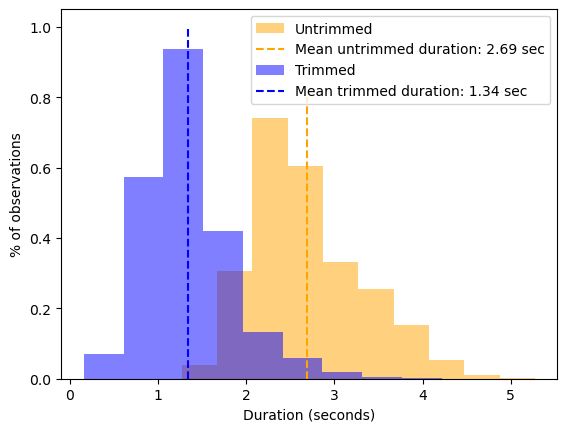

In [74]:
plt.figure()
plt.hist(df['duration_sec'],alpha=0.5,density=True,color='orange',label='Untrimmed')

plt.vlines(df['duration_sec'].mean(),ymin=0,ymax=0.8,label='Mean untrimmed duration: {:.2f} sec'.format(df['duration_sec'].mean()),linestyles='--',color='orange')

plt.hist(df['trimmed_duration_sec'],alpha=0.5,density=True,color='blue',label='Trimmed')

plt.vlines(df['trimmed_duration_sec'].mean(),ymin=0,ymax=1,label='Mean trimmed duration: {:.2f} sec'.format(df['trimmed_duration_sec'].mean()),linestyles='--',color='blue')

plt.xlabel('Duration (seconds)')
plt.ylabel('% of observations')
plt.legend()
plt.show()

**Observations**

The trimmed audio is shorter and more leptokurtic. Very few observations seem unreasonably short. Given this, we willll use the trimmed audio going forward.

We now examine duration and other summary statistics to look for meaningful differences across emotions that could help us distinguish between different emotions.

## Descriptive features have statistically significant difference in their means

### Conduct an ANOVA test to identify statistically significant differences among emotions
To compare differences among emotions for our extracted features, we will run the ANOVA test to examine the follwoing extracted features:
- Tempo
- Zero crossing rate
- Avg. spectral centroid
- Avg. spectral flatness
- Avg. spectral bandwidth
- Avg. spectral rolloff

For our examination we will use the following hypotheses

- $H_0$: The means of the emotion classes are all equal.

- $H_1$: There is at least some difference between the means of the emotion classes.

ANOVA test to dig deeper and see whether we can reject a null hypothesis that the mean durations for all emotions with the same sentence are equal.

Assumptions for ANOVA:
1. the observations should be independent,
2. the sample means should be normally distributed (which is implied by the CLT for large samples), and
3. the variance for each group should be the same.

Regarding these assumptions,
1. Within a single emotion and single sentence, we beleive that each recording is largely independent across actors. For Ravdess, each sentence was read twice by each actor twice, so there may be some violation of this assumption for those observations. However, Ravdess represents less than 15% of observations.
2. Each emotion has over 1,200 observations, so we believe that the central limit theorum will apply and allow us to conclude that sample means are normalluy distributed.
3. We do not know if variance is the same across emtoions. It is certainly possible that it is different, so we are not confident that this assumption is met.

We believe the first two assumptions are met, but are uncertain about the third. Despite that, we will proceed with performing the ANOVA test.

In [75]:
# initialize a dictionary to hold our anova data
anova_data = {}

# create a list of our different emotions
emotion_types = df["emotion"].unique()

# make every summary statistic that we wish to examine a key and set an empty dictionary as the value
summary_features = ['trimmed_duration_sec',
                    'tempo',
                    'avg_zero_crossing_rate',
                    'avg_spectral_centroid',
                    'avg_spectral_flatness',
                    'avg_spectral_rolloff',
                    'avg_spectral_bandwidth']

# iterate over all the summary features
for feature in summary_features:
    # create an empty dictionary for each summary feature
    anova_data[feature] = {}
    
    # iterate over all our emotions
    for emotion in emotion_types:
        anova_data[feature][emotion] = df.loc[df["emotion"] == emotion, feature]

In [76]:
# create a dictionary to hold our test results
anova_results = {}

# iterate over our summary features
for feature in summary_features:
    # create an array to hold our findings
    empty_array = np.empty((6,6,))
    # fill the array with NaNs
    empty_array[:] = np.nan
    # convert the array to a dataframe
    p_val_df = pd.DataFrame(empty_array)
    # rename the columns and index with the emotion classes
    p_val_df.index = emotion_types
    p_val_df.columns = emotion_types
    
    # iterate over the combinations of emotion types
    for combo in itertools.combinations(emotion_types,2):
        # for each pairs of emotion classes, claculate the p-value and store it in the dataframe
        p_val_df.loc[combo[1],combo[0]] = stats.f_oneway(anova_data[feature][combo[0]],
                                                         anova_data[feature][combo[1]])[1]
    
    # store the dataframe in the dictionary
    anova_results[feature] = p_val_df

### For tempo, distributions are very similar, but the null hypothesis is still rejected for 7 of 15 emotion combinations

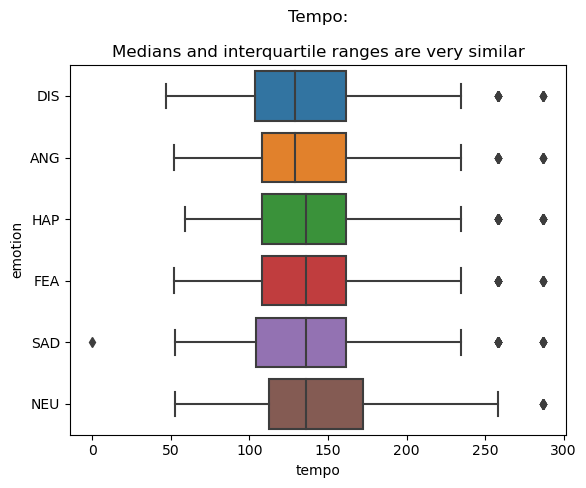

In [77]:
plt.figure()
sns.boxplot(data=df,x='tempo',y='emotion',order=['DIS','ANG','HAP','FEA','SAD','NEU'])
plt.title('Tempo:\n\nMedians and interquartile ranges are very similar')
plt.show()

The medians and interquartile ranges appear very similar. This suggests that tempo will not be particularly helpful in classifying emotion.

Let's look at the results of the anova test.

In [78]:
sig_p_vals = (anova_results['tempo']<0.01).sum().sum()
print(f'{sig_p_vals} of our 15 p-values are significant at the 0.01 level.\n')
print(f'Of the 15 combinations of emotions,\nwe reject the null hypothesis of equal population means for {sig_p_vals} combinations,\nbecause their p-values are below a 0.01 level of significance')

7 of our 15 p-values are significant at the 0.01 level.

Of the 15 combinations of emotions,
we reject the null hypothesis of equal population means for 7 combinations,
because their p-values are below a 0.01 level of significance


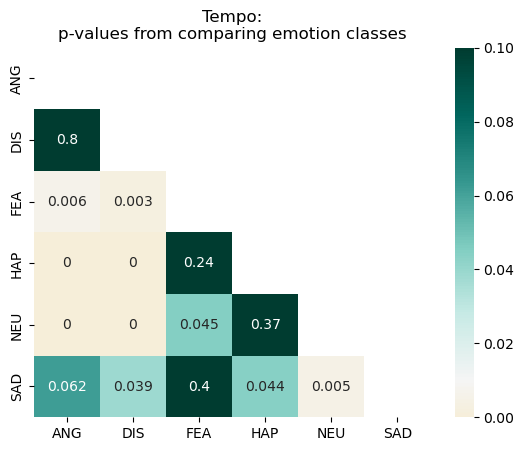

In [79]:
plt.figure()
sns.heatmap(anova_results['tempo'].round(3), annot=True, cmap='BrBG',center=0.01,vmax=0.1)
plt.title('Tempo:\np-values from comparing emotion classes')
plt.show()

**We only reject the null hypothesis of equal population means for seven of the emotion combinations**

Only two combination show p-values above out 0.01 threshold. Happiness and disgust are just slightly above our significance level. However, fear and happiness have a p-value near 0.1.

Given the similarities of the boxplots, it is surprising that we are able to reject the null hypothesis of equal population means for so many combinations. However, tempo alone is clearly not a good differentiator of emotion.

### For average zero crossing rate, distributions overlap, but the null hypothesis is still rejected for 13 of 15 emotion combinations

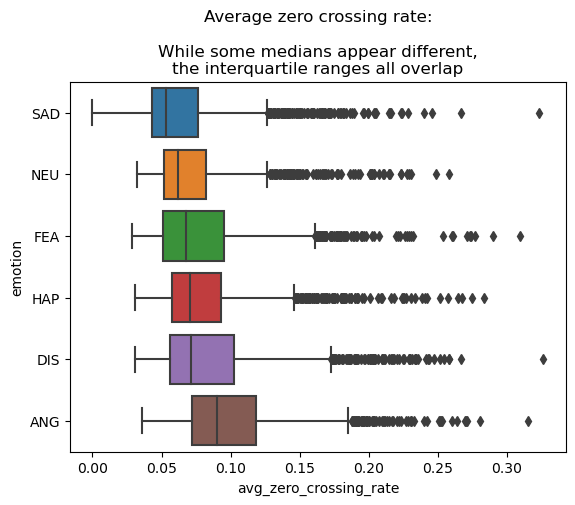

In [80]:
plt.figure()
sns.boxplot(data=df,x='avg_zero_crossing_rate',y='emotion',order=['SAD','NEU','FEA','HAP','DIS','ANG'])
plt.title('Average zero crossing rate:\n\nWhile some medians appear different,\nthe interquartile ranges all overlap')
plt.show()

For a few combinations of emotions (e.g. SAD and ANG), the medians appear to be significantly different. However, all of the interquartile ranges overlap with each other. This suggests that it would be very difficult to categorize the emotion of an observation based solely on average zero crossing rate.

Let's look at the results of the anova test to see whether we can reject the null hypothesis that the emotions all have the same mean.

In [81]:
sig_p_vals = (anova_results['avg_zero_crossing_rate']<0.01).sum().sum()
print(f'{sig_p_vals} of our 15 p-values are significant at the 0.01 level.\n')
print(f'Of the 15 combinations of emotions,\nwe reject the null hypothesis of equal population means for {sig_p_vals} combinations,\nbecause their p-values are below a 0.01 level of significance')

13 of our 15 p-values are significant at the 0.01 level.

Of the 15 combinations of emotions,
we reject the null hypothesis of equal population means for 13 combinations,
because their p-values are below a 0.01 level of significance


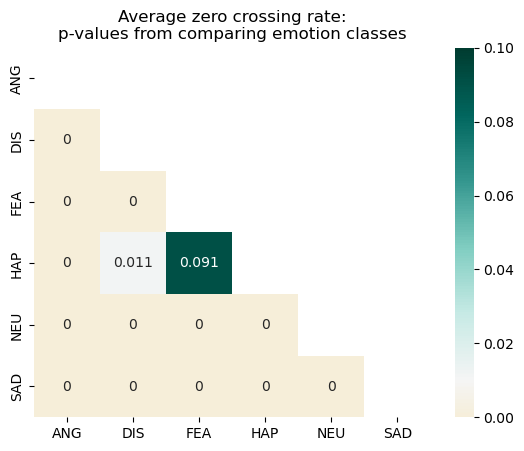

In [82]:
plt.figure()
sns.heatmap(anova_results['avg_zero_crossing_rate'].round(3), annot=True, cmap='BrBG',center=0.01,vmax=0.1)
plt.title('Average zero crossing rate:\np-values from comparing emotion classes')
plt.show()

**Despite overlapping distribution, we reject the null hypothesis of equal population means for all but two emotion combinations**

Only two combination show p-values above out 0.01 threshold. Happiness and disgust are just slightly above our significance level. However, fear and happiness have a p-value near 0.1.

Although the distributions of this feature across emotions overlap, the low p-values for most emotion combinations suggest that this feature could provide a useful contribution to classification efforts.

### For average spectral centroid, distributions overlap, but the null hypothesis is still rejected for 11 of 15 emotion combinations

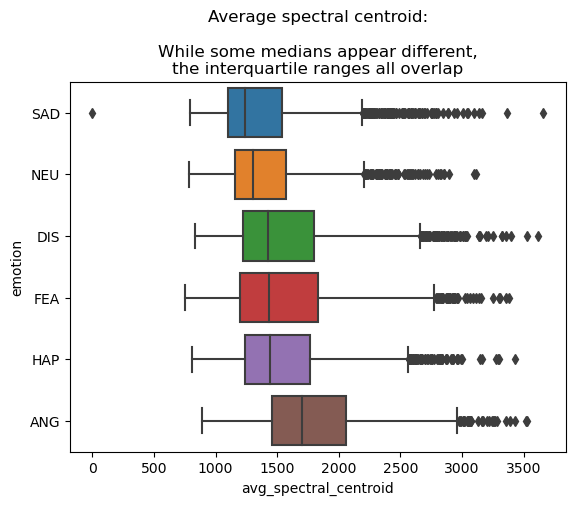

In [83]:
plt.figure()
sns.boxplot(data=df,x='avg_spectral_centroid',y='emotion',order=['SAD','NEU','DIS','FEA','HAP','ANG'])
plt.title('Average spectral centroid:\n\nWhile some medians appear different,\nthe interquartile ranges all overlap')
plt.show()

With the exception of DIS, FEA, HAP, the other three emotions appear to have different medians and different, though overlapping, distriubtions.

Let's look at the results of the anova test to see whether we can reject the null hypothesis that the emotions all have the same mean.

In [84]:
sig_p_vals = (anova_results['avg_spectral_centroid']<0.01).sum().sum()
print(f'{sig_p_vals} of our 15 p-values are significant at the 0.01 level.\n')
print(f'Of the 15 combinations of emotions,\nwe reject the null hypothesis of equal population means for {sig_p_vals} combinations,\nbecause their p-values are below a 0.01 level of significance')

11 of our 15 p-values are significant at the 0.01 level.

Of the 15 combinations of emotions,
we reject the null hypothesis of equal population means for 11 combinations,
because their p-values are below a 0.01 level of significance


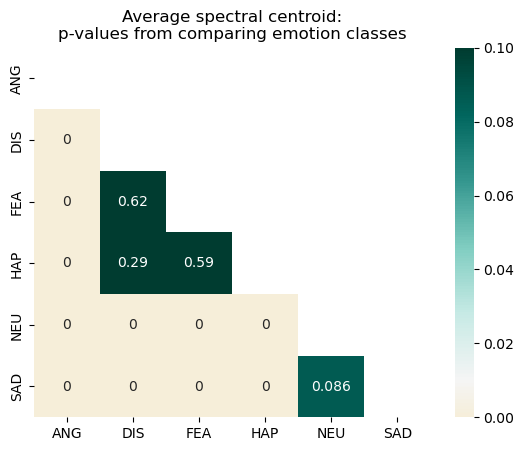

In [85]:
plt.figure()
sns.heatmap(anova_results['avg_spectral_centroid'].round(3), annot=True, cmap='BrBG',center=0.01,vmax=0.1)
plt.title('Average spectral centroid:\np-values from comparing emotion classes')
plt.show()

**We reject the null hypothesis of equal population means for all but four emotion combinations**

(FEA and DIS) and (HAP and FEA) and (HAP and DIS) have the highest p-values; all are at lease 0.29. The three emotions featured in these pairwise cominbations appear to have almost identical means in the boxplot, so it is not surprising that they have high p-values.

Although the distributions of this feature across emotions overlap, the low p-values for most emotion combinations suggest that this feature could provide a useful contribution to classification efforts.

### For average spectral flatness, distributions overlap, but the null hypothesis is still rejected for 7 of 15 emotion combinations

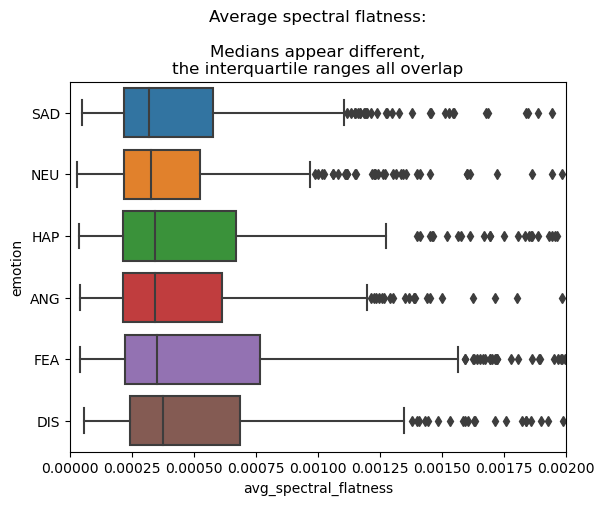

In [86]:
plt.figure()
sns.boxplot(data=df,x='avg_spectral_flatness',y='emotion',order=['SAD','NEU','HAP','ANG','FEA','DIS'])
plt.xlim(0,.002)
plt.title('Average spectral flatness:\n\nMedians appear different,\nthe interquartile ranges all overlap')
plt.show()

With the exception of DIS, FEA, HAP, the other three emotions appear to have different medians and different, though overlapping, distriubtions. There also appear to be far more outliers with this feature than with other features.

Let's look at the results of the anova test to see whether we can reject the null hypothesis that the emotions all have the same mean.

In [87]:
sig_p_vals = (anova_results['avg_spectral_flatness']<0.01).sum().sum()
print(f'{sig_p_vals} of our 15 p-values are significant at the 0.01 level.\n')
print(f'Of the 15 combinations of emotions,\nwe reject the null hypothesis of equal population means for {sig_p_vals} combinations,\nbecause their p-values are below a 0.01 level of significance')

7 of our 15 p-values are significant at the 0.01 level.

Of the 15 combinations of emotions,
we reject the null hypothesis of equal population means for 7 combinations,
because their p-values are below a 0.01 level of significance


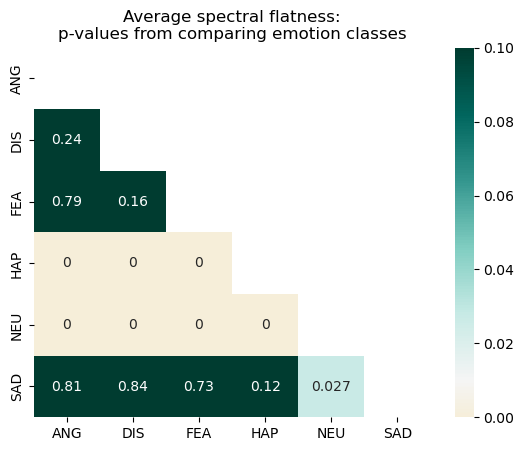

In [88]:
plt.figure()
sns.heatmap(anova_results['avg_spectral_flatness'].round(3), annot=True, cmap='BrBG',center=0.01,vmax=0.1)
plt.title('Average spectral flatness:\np-values from comparing emotion classes')
plt.show()

**We reject the null hypothesis of equal population means for seven emotion combinations**

Interestly, this feature shows p-value significance in (HAP,DIS) and (HAP,FEA), two combinations where average spectral centroid did not show significance. In concert with other features, this feature could provide a useful contribution to classification efforts.

### For average spectral rolloff, distributions overlap, but the null hypothesis is still rejected for 7 of 15 emotion combinations

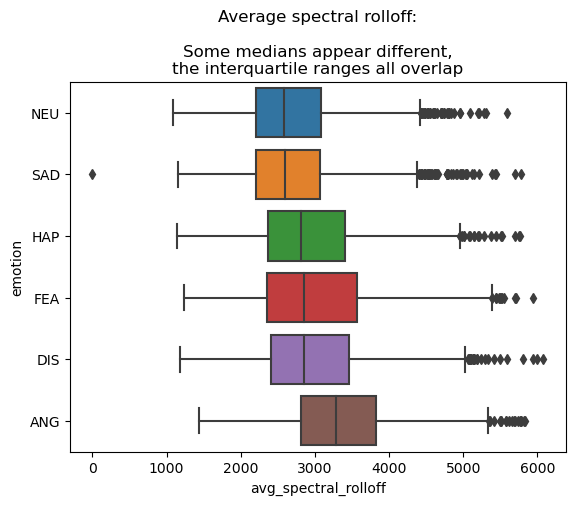

In [89]:
plt.figure()
sns.boxplot(data=df,x='avg_spectral_rolloff',y='emotion',order=['NEU','SAD','HAP','FEA','DIS','ANG'])
plt.title('Average spectral rolloff:\n\nSome medians appear different,\nthe interquartile ranges all overlap')
plt.show()

There appear to be three groupings here:
- Neutral and Sad appear to have the same median and interquartile range
- Happiness, fear, and disgust appear to have the same median and similar iterquartile ranges
- Anger appears different from the other emotions

Let's look at the results of the anova test to see whether we can reject the null hypothesis that the emotions all have the same mean.

In [90]:
sig_p_vals = (anova_results['avg_spectral_rolloff']<0.01).sum().sum()
print(f'{sig_p_vals} of our 15 p-values are significant at the 0.01 level.\n')
print(f'Of the 15 combinations of emotions,\nwe reject the null hypothesis of equal population means for {sig_p_vals} combinations,\nbecause their p-values are below a 0.01 level of significance')

11 of our 15 p-values are significant at the 0.01 level.

Of the 15 combinations of emotions,
we reject the null hypothesis of equal population means for 11 combinations,
because their p-values are below a 0.01 level of significance


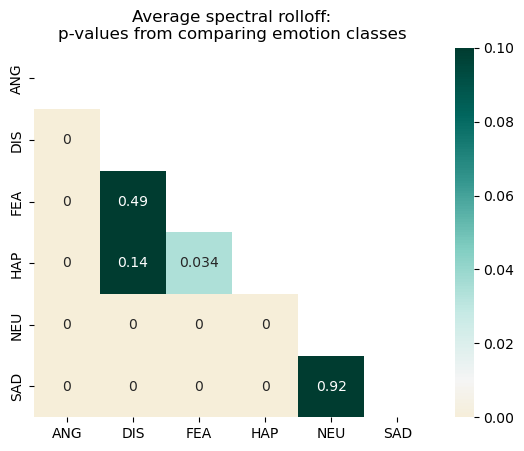

In [91]:
plt.figure()
sns.heatmap(anova_results['avg_spectral_rolloff'].round(3), annot=True, cmap='BrBG',center=0.01,vmax=0.1)
plt.title('Average spectral rolloff:\np-values from comparing emotion classes')
plt.show()

**We reject the null hypothesis of equal population means for 11 emotion combinations**

Interestly, this feature shows p-value significance in the exact same cominbaitons as average spectral centroid. This suggests that it may not add much predictive value beyond what average spectral centroid already provides.

### For average spectral bandwidth, distributions overlap, but the null hypothesis is still rejected for 7 of 15 emotion combinations

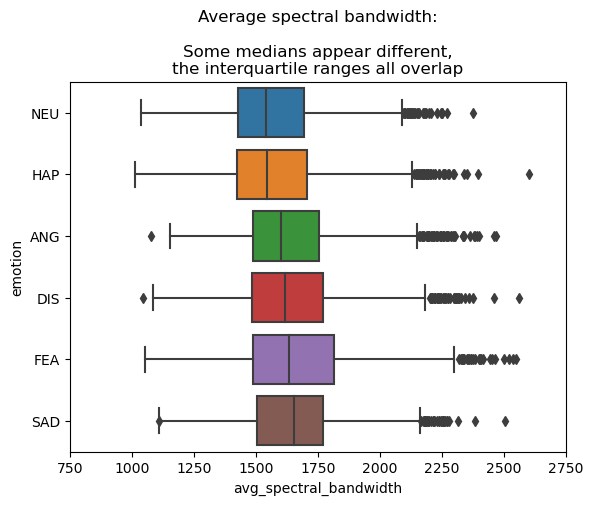

In [92]:
plt.figure()
sns.boxplot(data=df,x='avg_spectral_bandwidth',y='emotion',order=['NEU','HAP','ANG','DIS','FEA','SAD'])
plt.title('Average spectral bandwidth:\n\nSome medians appear different,\nthe interquartile ranges all overlap')
plt.xlim(750,2750)
plt.show()

While medians appear different, the intequartile ranges overlap.

In [93]:
sig_p_vals = (anova_results['avg_spectral_bandwidth']<0.01).sum().sum()
print(f'{sig_p_vals} of our 15 p-values are significant at the 0.01 level.\n')
print(f'Of the 15 combinations of emotions,\nwe reject the null hypothesis of equal population means for {sig_p_vals} combinations,\nbecause their p-values are below a 0.01 level of significance')

10 of our 15 p-values are significant at the 0.01 level.

Of the 15 combinations of emotions,
we reject the null hypothesis of equal population means for 10 combinations,
because their p-values are below a 0.01 level of significance


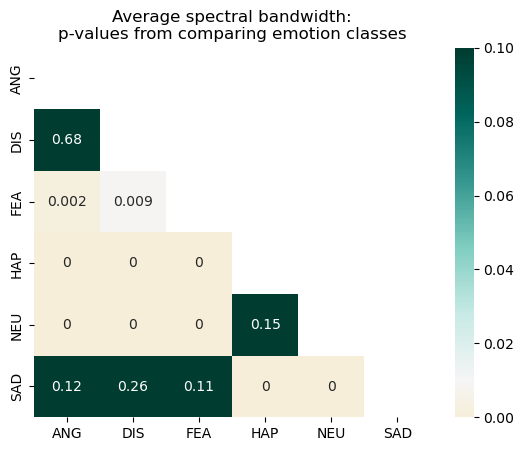

In [94]:
plt.figure()
sns.heatmap(anova_results['avg_spectral_bandwidth'].round(3), annot=True, cmap='BrBG',center=0.01,vmax=0.1)
plt.title('Average spectral bandwidth:\np-values from comparing emotion classes')
plt.show()

**We reject the null hypothesis of equal population means for 10 emotion combinations**

### Certain emotion combinations are likely to be easieer to distinguish than others

For each of the 15 different combinations of emotions, we can tally for how many of the features we rejected the null hypothesis of population mean equivalence. This may provide some indication of which emotions are easiest to distinguish.

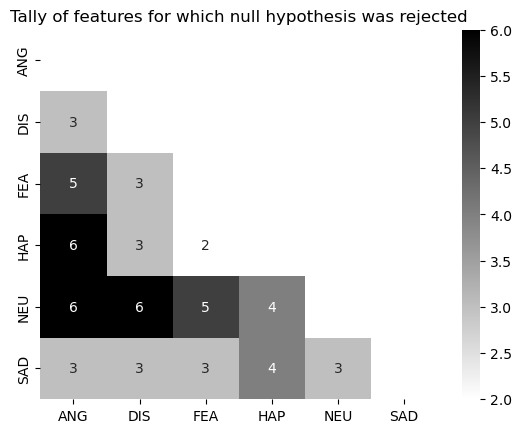

In [95]:
# inialize a summary dataframe of Nans using the same process as before
empty_array = np.empty((6,6,))
empty_array[:] = np.nan
p_val_sum_df = pd.DataFrame(empty_array)
p_val_sum_df.index = emotion_types
p_val_sum_df.columns = emotion_types

# create a list of our summary features
features = list(anova_results.keys())
# remove duration, since we believe that is only narrowly applicable to this dataset and can't be generalized for natural speech
features.remove('trimmed_duration_sec')

# iterate over our list of summary features
for feature in features:
        # iterate over our combinations of emotions
        for combo in itertools.combinations(emotion_types,2):
            # check whether there is non-NaN value in the feature's p-value dataframe
            if ~(np.isnan(anova_results[feature].loc[combo[1],combo[0]])):
                # if the value is not NaN, proceed; otherwise, if it is a NaN, we won't update our summary dataframe
                # set the tally counter to zero on the assumption that the p-value is not significant
                tally = 0
                if anova_results[feature].loc[combo[1],combo[0]] < 0.01:
                    # if the p-value is significant, set the tally counter to 1
                    tally = 1
                # check whether the summary table already had a non-null value
                if np.isnan(p_val_sum_df.loc[combo[1],combo[0]]):
                    # if it is a NaN, replace the NaN with tally counter value
                    p_val_sum_df.loc[combo[1],combo[0]] = tally
                else:
                    # if it is not a NaN, then increment the current value with the tally counter value
                    p_val_sum_df.loc[combo[1],combo[0]] += tally

plt.figure()
sns.heatmap(p_val_sum_df, annot=True, cmap='gray_r')
plt.title('Tally of features for which null hypothesis was rejected')
plt.show()

**Observations**
Three emotion combination standout as having the most features where the null hypothesis is rejected. These may be combinations where it is easier to distinguish between emotions:
- ANG, HAP
- ANG, NEU
- NEU, DIS

There is also one combination that has the lowest tally. This is HAP and FEA. This pair may be difficult to distinguish.

## Pickle the dataframe and dictionary for use in the next notebook
- Pickle the dataframe
- Pickle the dictionary of trimmed audio files

**Pickle the dataframe**

In [97]:
df.to_pickle('dataframes_and_dictionaries/concatenated_observations.pkl')

In [98]:
# check whether the pickling will allow an identical dataframe to be reloaded
unpickled_df = pd.read_pickle('dataframes_and_dictionaries/concatenated_observations.pkl')
df.equals(unpickled_df)

True

**Pickle the dictionary of trimmed audio**

In [99]:
%%time
# pickle the dicitonary
with open('dataframes_and_dictionaries/trimmed_audio_dict.pkl', 'wb') as handle:
    pickle.dump(trimmed_audio_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

CPU times: total: 14 s
Wall time: 27 s


In [100]:
# open the pickled file
with open('dataframes_and_dictionaries/trimmed_audio_dict.pkl', 'rb') as handle:
    b = pickle.load(handle)

In [101]:
# check the length of the original dictionary
len(trimmed_audio_dict.keys())

8491

In [102]:
# check th elength of the dictionary extracted from the pickle
len(b.keys())

8491

They both have the same length

In [103]:
# initialize a list to for checking whether the stored arrays in the orignal and pickled dictionary are the same
truth_list = []

# iterate over the keys in the pickled dictionary
for key in b.keys():
    # check whether the arrays stored in each dictionary for a given key are equal;
    # store this boolean value in the truth_list
    truth_list.append(np.array_equal(trimmed_audio_dict[key]['y'],b[key]['y']))

# check whether the truth_list contains any False values
set(truth_list)

{True}

All the values are equal.

## When visualized with a waveform and Mel-frequency spectrogram, different emotions appear different.
- Let's examine whether an emotion appears different when visualized with waveforms and spectrograms
- First we look at a single actore speaking a single sentence
- Next, we look at the average of all actors speaking the same sentence
- We observe that while the visualizations for each emotion appear different, the differences are subtle

### Examine a specific actor's rendition of different emotions across the same sentence

In [104]:
# set a condition to pull files for a specific actor and a specific emotion
condition = (df['source'] == 'crema') & (df['actor'] == 'cd_1091') & (df['sentence'] == 'DFA')
# inspect the sample
df[condition]

path             basename  \
7354  raw_data/crema_d\AudioWAV\1091_DFA_ANG_XX.wav  1091_DFA_ANG_XX.wav   
7355  raw_data/crema_d\AudioWAV\1091_DFA_DIS_XX.wav  1091_DFA_DIS_XX.wav   
7356  raw_data/crema_d\AudioWAV\1091_DFA_FEA_XX.wav  1091_DFA_FEA_XX.wav   
7357  raw_data/crema_d\AudioWAV\1091_DFA_HAP_XX.wav  1091_DFA_HAP_XX.wav   
7358  raw_data/crema_d\AudioWAV\1091_DFA_NEU_XX.wav  1091_DFA_NEU_XX.wav   
7359  raw_data/crema_d\AudioWAV\1091_DFA_SAD_XX.wav  1091_DFA_SAD_XX.wav   

        actor sentence emotion intensity  duration_sec     sex source  \
7354  cd_1091      DFA     ANG        XX      2.002000  female  crema   
7355  cd_1091      DFA     DIS        XX      2.669313  female  crema   
7356  cd_1091      DFA     FEA        XX      2.002000  female  crema   
7357  cd_1091      DFA     HAP        XX      2.002000  female  crema   
7358  cd_1091      DFA     NEU        XX      2.002000  female  crema   
7359  cd_1091      DFA     SAD        XX      2.002000  female  crema   

      trimmed_duration_sec       tempo  avg_zero_crossing_rate  \
7354              0.905578  123.046875                0.132751   
7355              0.859138  135.999178                0.099905   
7356              0.673379  215.332031                0.108610   
7357              0.905578  172.265625                0.085144   
7358              0.626939  135.999178                0.075562   
7359              1.927256  135.999178                0.045207   

      avg_spectral_centroid  avg_spectral_flatness  avg_spectral_rolloff  \
7354            2223.571601               0.000362           4062.507935   
7355            1882.389211               0.001174           3853.876696   
7356            2051.642282               0.001011           4301.975098   
7357            1669.728431               0.000554           3320.689087   
7358            1655.795411               0.001984           3422.625732   
7359            1268.078378               0.000227           2730.743408   

      avg_spectral_bandwidth  
7354             1761.680794  
7355             1881.239570  
7356             1950.326479  
7357             1771.730229  
7358             1794.538964  
7359             1768.980225

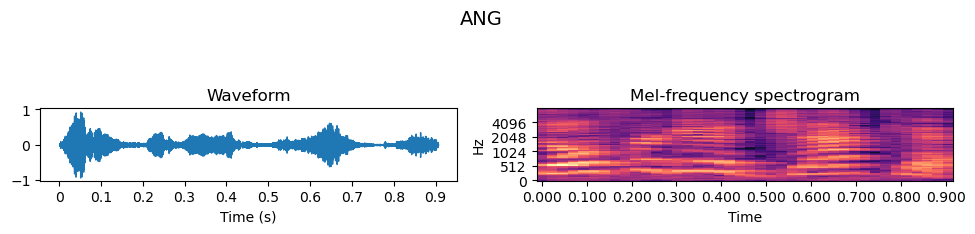

-------------------------------------


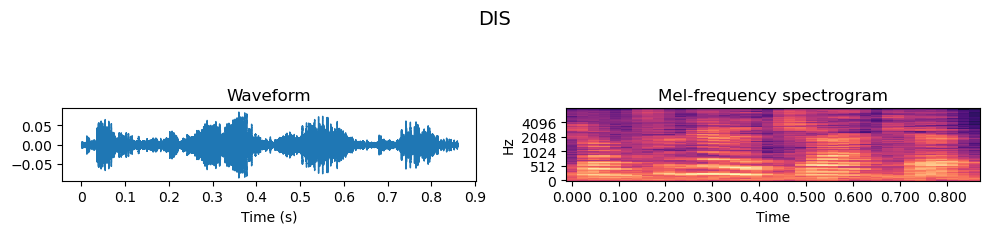

-------------------------------------


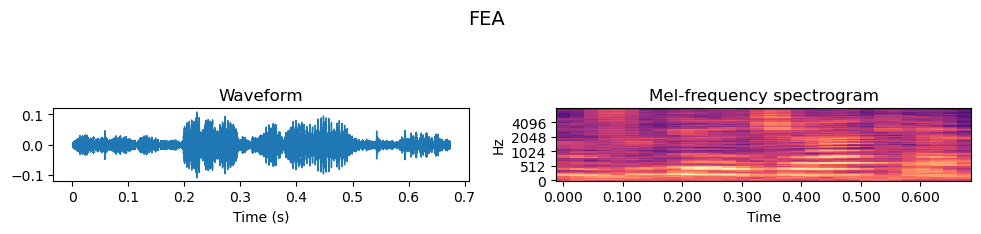

-------------------------------------


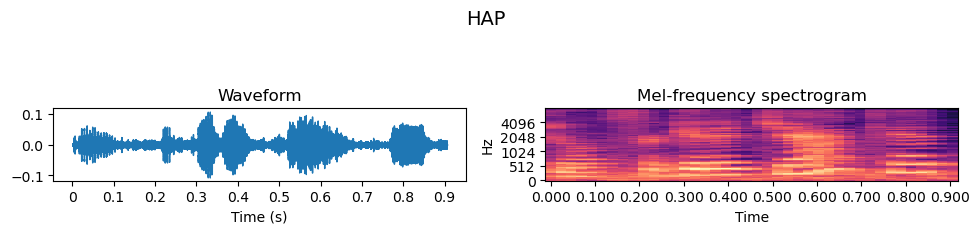

-------------------------------------


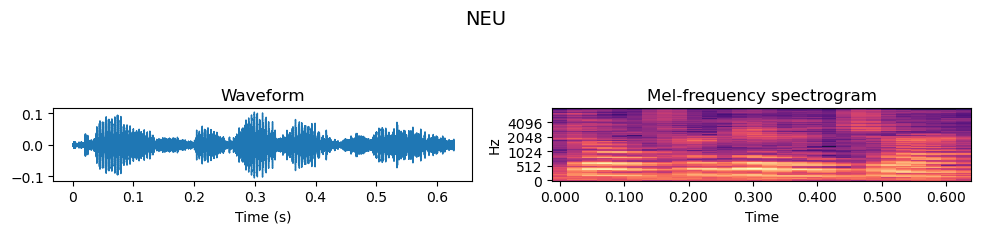

-------------------------------------


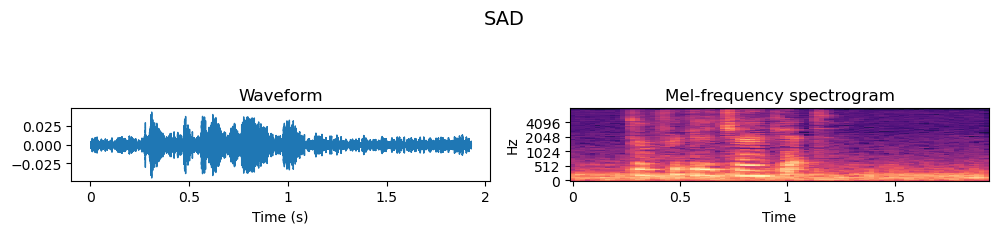

-------------------------------------


In [106]:
# Let's plot the waveforms and audio

for index,file in df[condition]['path'].items():
    y,sr = librosa.load(file)
    #trim silence off the audio with a threshold of 20dB
    yt, i = librosa.effects.trim(y,top_db=11)
    # calculate th mel spectrogram
    S = librosa.feature.melspectrogram(y=yt, sr=sr, n_mels=128, fmax=8000)
    # conver the y-axis to decibels
    S_dB = librosa.power_to_db(S, ref=np.max)
    
    # plot the waveform
    plt.subplots(1,2,figsize=(10,2))
    plt.suptitle(df.loc[index,'emotion'],y=1.15,fontsize=14)    
    plt.subplot(1,2,1)

    librosa.display.waveshow(yt, sr=sr,x_axis='s')
    plt.title('Waveform')
    
    # plot the spectrogram
    plt.subplot(1,2,2)
    librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=sr, fmax=8000)
    plt.title('Mel-frequency spectrogram')
    plt.tight_layout()
    plt.show()
    display(Audio(data=yt, rate=sr))
    print('-------------------------------------')

**Observations**

Clearly, some difference between the emotions is being captured by the waveform and spectrogram. However, it is difficult to identify the specific differences. We will rely on the model to extract these differences.

### Examination of the average rendition of different emotions across the same sentence
We will combine combine the emotions by taking an average. We will use some functions.

#### Select a sample

In [107]:
# select a sample of a specific sentence across all actors for all emotions
condition2 = (df['source'] == 'crema') & (df['sentence'] == 'DFA')
df[condition2]

path             basename  \
0     raw_data/crema_d\AudioWAV\1001_DFA_ANG_XX.wav  1001_DFA_ANG_XX.wav   
1     raw_data/crema_d\AudioWAV\1001_DFA_DIS_XX.wav  1001_DFA_DIS_XX.wav   
2     raw_data/crema_d\AudioWAV\1001_DFA_FEA_XX.wav  1001_DFA_FEA_XX.wav   
3     raw_data/crema_d\AudioWAV\1001_DFA_HAP_XX.wav  1001_DFA_HAP_XX.wav   
4     raw_data/crema_d\AudioWAV\1001_DFA_NEU_XX.wav  1001_DFA_NEU_XX.wav   
...                                             ...                  ...   
7355  raw_data/crema_d\AudioWAV\1091_DFA_DIS_XX.wav  1091_DFA_DIS_XX.wav   
7356  raw_data/crema_d\AudioWAV\1091_DFA_FEA_XX.wav  1091_DFA_FEA_XX.wav   
7357  raw_data/crema_d\AudioWAV\1091_DFA_HAP_XX.wav  1091_DFA_HAP_XX.wav   
7358  raw_data/crema_d\AudioWAV\1091_DFA_NEU_XX.wav  1091_DFA_NEU_XX.wav   
7359  raw_data/crema_d\AudioWAV\1091_DFA_SAD_XX.wav  1091_DFA_SAD_XX.wav   

        actor sentence emotion intensity  duration_sec     sex source  \
0     cd_1001      DFA     ANG        XX      2.275562    male  crema   
1     cd_1001      DFA     DIS        XX      2.335688    male  crema   
2     cd_1001      DFA     FEA        XX      2.168813    male  crema   
3     cd_1001      DFA     HAP        XX      1.868500    male  crema   
4     cd_1001      DFA     NEU        XX      2.035375    male  crema   
...       ...      ...     ...       ...           ...     ...    ...   
7355  cd_1091      DFA     DIS        XX      2.669313  female  crema   
7356  cd_1091      DFA     FEA        XX      2.002000  female  crema   
7357  cd_1091      DFA     HAP        XX      2.002000  female  crema   
7358  cd_1091      DFA     NEU        XX      2.002000  female  crema   
7359  cd_1091      DFA     SAD        XX      2.002000  female  crema   

      trimmed_duration_sec       tempo  avg_zero_crossing_rate  \
0                 0.975238  143.554688                0.102289   
1                 0.835918  107.666016                0.103357   
2                 0.626939  151.999081                0.094796   
3                 0.696599  215.332031                0.092537   
4                 0.789478  172.265625                0.081989   
...                    ...         ...                     ...   
7355              0.859138  135.999178                0.099905   
7356              0.673379  215.332031                0.108610   
7357              0.905578  172.265625                0.085144   
7358              0.626939  135.999178                0.075562   
7359              1.927256  135.999178                0.045207   

      avg_spectral_centroid  avg_spectral_flatness  avg_spectral_rolloff  \
0               1750.083310               0.000503           3289.822743   
1               1792.732228               0.001253           3311.457454   
2               1765.430726               0.000280           3116.546631   
3               1757.988631               0.000141           3377.239793   
4               1600.272876               0.000659           3076.787109   
...                     ...                    ...                   ...   
7355            1882.389211               0.001174           3853.876696   
7356            2051.642282               0.001011           4301.975098   
7357            1669.728431               0.000554           3320.689087   
7358            1655.795411               0.001984           3422.625732   
7359            1268.078378               0.000227           2730.743408   

      avg_spectral_bandwidth  
0                1565.241479  
1                1620.208555  
2                1569.032275  
3                1588.819764  
4                1542.359354  
...                      ...  
7355             1881.239570  
7356             1950.326479  
7357             1771.730229  
7358             1794.538964  
7359             1768.980225  

[546 rows x 16 columns]

#### Define functions to pad the audio to all be same length so that we can take an average

In [108]:
def max_dims_1D(input_list,v=True):
    '''
    iterates over a list of 1D arrays to find the max and min lengths of the arrays
    
    INPUT:
    ------
    input_list - a list of 1D numpy arrays or tuples
    v - a Boolean that defaults to True;
     - True means that it will print out the maximum and minimum numbe of rows and columns across the full list;
     - False means that it will not print
    
    OUTPUT:
    -------
    an integer being maximum length of any array in the input list

    '''
    lengths = []

    for x in input_list:
        lengths.append(len(x))
    
    if v:
        print(f'min length: {min(lengths)}')
        print(f'max length: {max(lengths)}')
        
    
    return max(lengths)

In [109]:
# Let's pad all of our matrices
def pad_array_list_1D(input_list):
    '''
    iterates over a list of 1D matrixes or tuples,
    pads smaller arrays with zeros on right all tuples have the same shape
    
    INPUT:
    ------
    input_list - a list of 1D numpy arrays or tuples
    
    OUTPUT:
    -------
    a list of numpy arrays all have the same shape:
    - the same number of rowss as the input array with the largest number of rows
    - the same number of columns as the input array with the largest number of columns
    
    '''

    #inialize a list to hold the results
    results_padded = []

    # find the maximum number of rows across all input arrays
    max_length = max_dims_1D(input_list,v=False)
    
    for array in input_list:
        padded_array = np.pad(array,((0,max_length - array.shape[0])),mode='constant',constant_values=0)
        results_padded.append(padded_array)
    
    return results_padded

#### Calculate and visualize the average

In [110]:
%%time

#initialize a dictionary to hold the calculated average audio for each array
avg_dict = {}

# iterate over our six emotion classes
for emotion in df['emotion'].unique():
    print('-----------')
    print(emotion)
    print('-----------\n')
    
    # initialize a list to hold the all the audio files for a given emotion
    audio = list()
    # iterate over all the file basenmaes for the files that meet our sampling condition and have the current emotion class
    for basename in df[condition2 & (df['emotion'] == emotion)]['basename']:
        
        # append the audio files to the list
        audio.append(trimmed_audio_dict[basename]['y'])
        
    # use our paddind funciton to pad shorters arrays with zeros at the end such that all the arrays have the same length
    audio = pad_array_list_1D(audio)
    
    # take the average of all the audio arrays
    average = sum(audio) / len(audio)
    print(average)
    # store the average audio array in our dictionary
    avg_dict[emotion] = average

-----------
ANG
-----------

[-0.00120288 -0.00040219  0.00018199 ...  0.0005302   0.00059266
  0.00062693]
-----------
DIS
-----------

[ 4.9731828e-04  2.8727410e-04  6.4214924e-04 ...  1.2385129e-06
 -7.0036026e-06 -1.0274688e-05]
-----------
FEA
-----------

[-1.0582122e-03 -2.6014019e-03 -2.8143886e-03 ...  2.0930581e-12
 -7.8585429e-13  0.0000000e+00]
-----------
HAP
-----------

[6.4652124e-03 6.4085959e-03 6.0075894e-03 ... 6.2897328e-05 5.3630487e-05
 4.9764116e-05]
-----------
NEU
-----------

[ 9.0458064e-04  7.7625486e-04 -2.4874278e-04 ... -9.0591275e-06
 -6.8314462e-06 -4.3643754e-06]
-----------
SAD
-----------

[-3.3953079e-04  1.3050225e-04 -4.7954753e-05 ...  3.4386674e-05
  3.5021763e-05  3.6969574e-05]
CPU times: total: 188 ms
Wall time: 195 ms


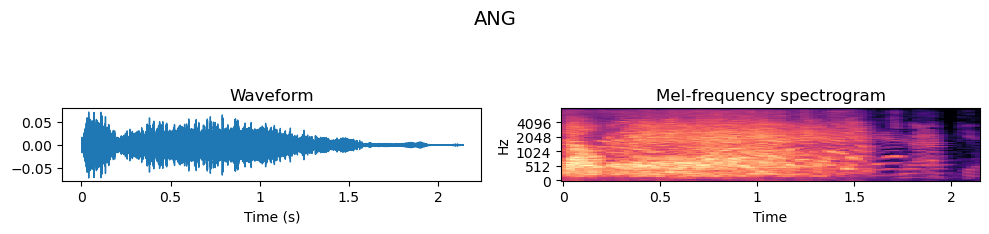

-------------------------------------


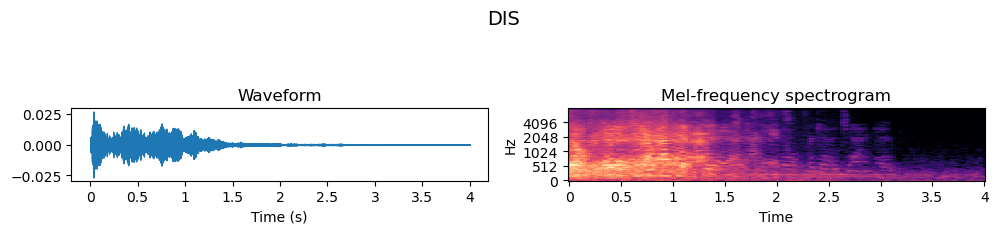

-------------------------------------


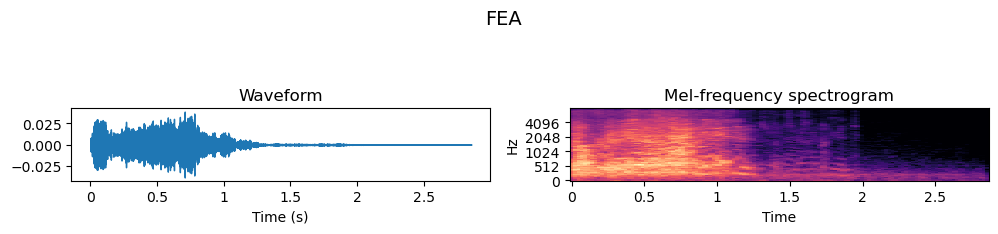

-------------------------------------


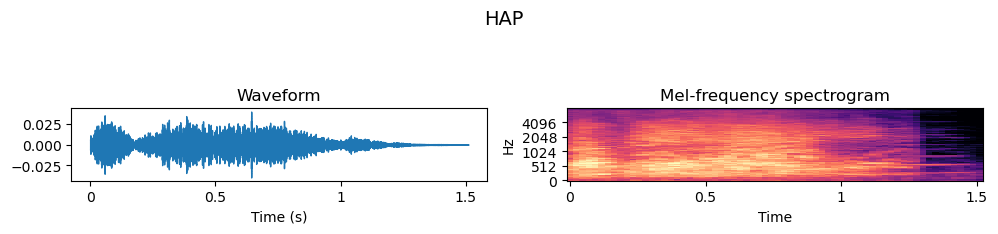

-------------------------------------


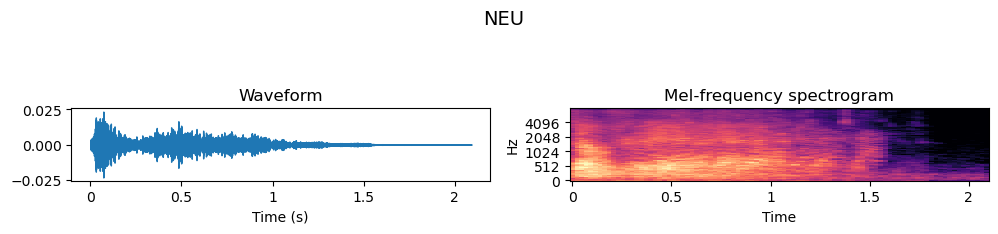

-------------------------------------


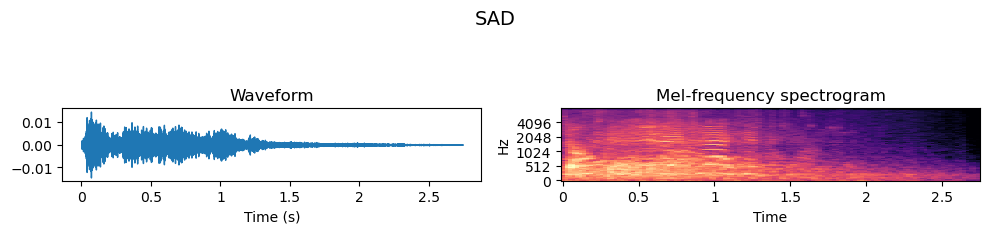

-------------------------------------


In [112]:
# Let's plot the waveforms and audio

# iterate over the emotion classes
for emotion in df['emotion'].unique():
    # pull the average audio array from the dictionary we just created
    y = avg_dict[emotion]
    sr=22050
    # caclulate the mel spectrogram
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
    # calculate the decibel level
    S_dB = librosa.power_to_db(S, ref=np.max)
    
    plt.subplots(1,2,figsize=(10,2))
    plt.suptitle(emotion,y=1.15,fontsize=14)    
    plt.subplot(1,2,1)

    librosa.display.waveshow(y, sr=sr,x_axis='s')
    plt.title('Waveform')
    
    plt.subplot(1,2,2)
    librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=sr, fmax=8000)
    plt.title('Mel-frequency spectrogram')
    plt.tight_layout()
    plt.show()
    display(Audio(data=y, rate=sr))
    print('-------------------------------------')

**Averages sound like a crowd all speaking at once**

The averages sound like all the people talking at once. In that cacophony, some meaning may be lost. As a listener, it seems harder to identify emotion.

Looking at the spectrograms, they do look different. However, it seems some texture and granular detail are lost. The visual differences are unlikely to help a human distinguish between emotions. However, they may provide value to a neural network model.